# 필요 라이브러리 가져오기

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.manifold
# import collections
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline
%config InlineBackend.figure_format='retina'

# 1) EDA 

## 1-1) 데이터셋 불러오기

In [2]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

## 1-2) 평점 시스템 변환 

### 2단계 평점 시스템
5점만점 시스템 (5단계, 10단계에서) 2단계로 변환

- 0.5 ~ 2.5점 (1.0 ~ 5.0점) 이하는 '싫어요'
- 3.0 ~ 5.0점 (6.0 ~ 10.0점) 이상은 '좋아요'

In [3]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931
...,...,...,...,...
100831,610,166534,4.00,1493848402
100832,610,168248,5.00,1493850091
100833,610,168250,5.00,1494273047
100834,610,168252,5.00,1493846352


In [4]:
# 5보다 작은 평점은 -1(싫어요)
ratings['rating_2'] = ratings['rating'].apply(lambda x: np.where(x <= 2.5, (-1),x))

# 6보다 높은 평점은 1(좋아요)
ratings['rating_2'] = ratings['rating_2'].apply(lambda x: np.where(x >= 3,1,x))

In [5]:
ratings

,userId,movieId,rating,timestamp,rating_2
0,1,1,4.00,964982703,1.00
1,1,3,4.00,964981247,1.00
2,1,6,4.00,964982224,1.00
3,1,47,5.00,964983815,1.00
4,1,50,5.00,964982931,1.00
...,...,...,...,...,...
100831,610,166534,4.00,1493848402,1.00
100832,610,168248,5.00,1493850091,1.00
100833,610,168250,5.00,1494273047,1.00
100834,610,168252,5.00,1493846352,1.00


### 새로운 평점 시스템 (3단계로 변환)

- 0.5 ~ 2.0점 (1 ~ 4점) '싫어요' (부정)
- 2.5 ~ 3.5점 (5 ~ 7점) '보통이에요' (중립이지만 긍정은 아니다.)
- 4.0 ~ 5.0점 (8 ~ 10점) '좋아요' (긍정)

In [6]:
ratings['rating_3'] = ratings['rating'].apply(lambda x: np.where(x <= 2, (-1),x))
ratings['rating_3'] = ratings['rating_3'].apply(lambda x: np.where(x >= 2.5 and x <= 3.5, 0,x))
ratings['rating_3'] = ratings['rating_3'].apply(lambda x: np.where(x >= 4, 1,x))

In [99]:
ratings.drop(labels='timestamp', axis=1)

,userId,movieId,rating,rating_2,rating_3
0,1,1,4.00,1.00,1.00
1,1,3,4.00,1.00,1.00
2,1,6,4.00,1.00,1.00
3,1,47,5.00,1.00,1.00
4,1,50,5.00,1.00,1.00
...,...,...,...,...,...
100831,610,166534,4.00,1.00,1.00
100832,610,168248,5.00,1.00,1.00
100833,610,168250,5.00,1.00,1.00
100834,610,168252,5.00,1.00,1.00


In [100]:
ratings.drop(labels='timestamp', axis=1).describe()

,userId,movieId,rating,rating_2,rating_3
count,100836.00,100836.00,100836.00,100836.00,100836.00
mean,326.13,19435.30,3.50,0.62,0.35
std,182.62,35530.99,1.04,0.78,0.70
min,1.00,1.00,0.50,-1.00,-1.00
25%,177.00,1199.00,3.00,1.00,0.00
50%,325.00,2991.00,3.50,1.00,0.00
75%,477.00,8122.00,4.00,1.00,1.00
max,610.00,193609.00,5.00,1.00,1.00


In [9]:
ratings

,userId,movieId,rating,timestamp,rating_2,rating_3
0,1,1,4.00,964982703,1.00,1.00
1,1,3,4.00,964981247,1.00,1.00
2,1,6,4.00,964982224,1.00,1.00
3,1,47,5.00,964983815,1.00,1.00
4,1,50,5.00,964982931,1.00,1.00
...,...,...,...,...,...,...
100831,610,166534,4.00,1493848402,1.00,1.00
100832,610,168248,5.00,1493850091,1.00,1.00
100833,610,168250,5.00,1494273047,1.00,1.00
100834,610,168252,5.00,1493846352,1.00,1.00


## 1-3) Create User Dataset

In [10]:
# Creating User DataSet

users = (ratings
         .groupby(by='userId', as_index=False)
         .agg({'rating': ['count', 'mean'],'rating_2':'mean', 'rating_3':'mean'}))

# hierarchical columns Flatten
users.columns = [' '.join(col).strip() for col in users] 

users

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
0,1,232,4.37,0.95,0.84
1,2,29,3.95,0.86,0.62
2,3,39,2.44,-0.08,-0.13
3,4,216,3.56,0.55,0.37
4,5,44,3.64,0.82,0.43
...,...,...,...,...,...
605,606,1115,3.66,0.78,0.51
606,607,187,3.79,0.86,0.52
607,608,831,3.13,0.38,0.14
608,609,37,3.27,1.00,0.27


In [11]:
users.describe()

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
count,610.00,610.00,610.00,610.00,610.00
mean,305.50,165.30,3.66,0.71,0.44
std,176.24,269.48,0.48,0.28,0.29
min,1.00,20.00,1.27,-1.00,-0.90
25%,153.25,35.00,3.36,0.58,0.26
50%,305.50,70.50,3.69,0.79,0.48
75%,457.75,168.00,4.00,0.91,0.65
max,610.00,2698.00,5.00,1.00,1.00


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 0 to 609
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userId         610 non-null    int64  
 1   rating count   610 non-null    int64  
 2   rating mean    610 non-null    float64
 3   rating_2 mean  610 non-null    float64
 4   rating_3 mean  610 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 28.6 KB


Text(0.06, 0.5, 'Number of Users')

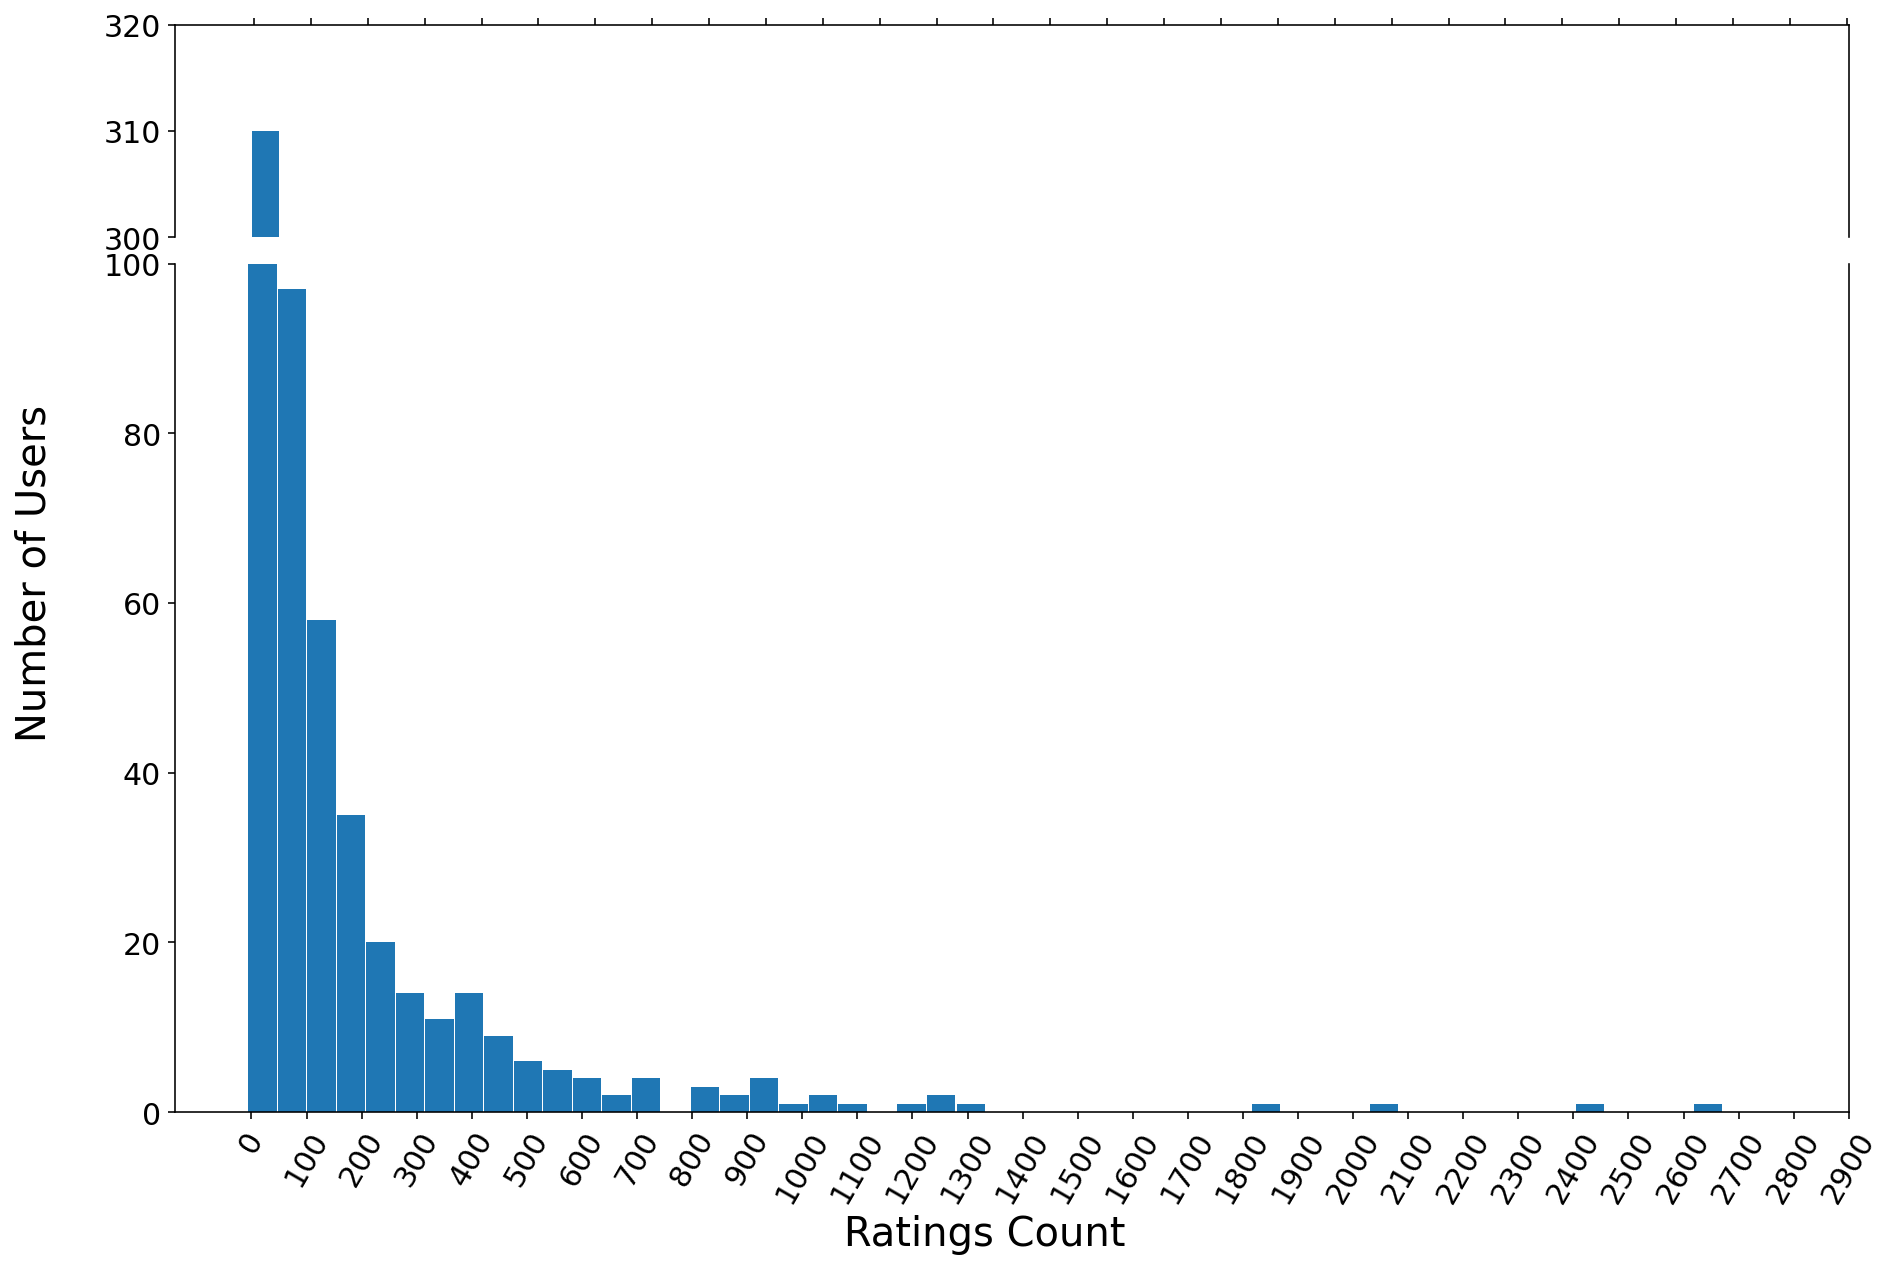

In [13]:
rate_hist_plot, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[1, 4]}, sharex=True, figsize=(15,10))

rate_hist_plot.subplots_adjust(hspace=0.05)

ax1.hist(x='rating count', data=users, bins=50,rwidth=0.9, align='left')
ax2.hist(x='rating count', data=users, bins=50, rwidth=0.95, align='left')

ax1.set_ylim(300,320)
ax2.set_ylim(0, 100)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax1.set_yticks(ticks=[300,310,320])
ax2.set_xticks(ticks=range(0,3000,100))

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax2.tick_params(axis='x', which='major', labelsize=15, labelrotation=60)

rate_hist_plot.text(0.5, 0.04, 'Ratings Count', ha='center', va='center', size=20)
rate_hist_plot.text(0.06, 0.5, 'Number of Users', ha='center', va='center', rotation='vertical', size=20)

위의 그래프를 보면. (총 유저의 수 610)
- 50%의 사용자들이 0~50개의 리뷰를 남겼다. (310/610) (50.8%)
- 100명 정도의 유저가 50~100개의 리뷰를 남김 (100/610) (16.4%)
- 1300편 이상의 평점을 남긴 유저도 있지만 Outlier값이라고 생각할 수 있다.

## 사용자들의 평균평점 분포도

아래 그래프들은 **사용자의 평균 평점**을 나타낸것이다.

### 5점 만점 평가 시각화

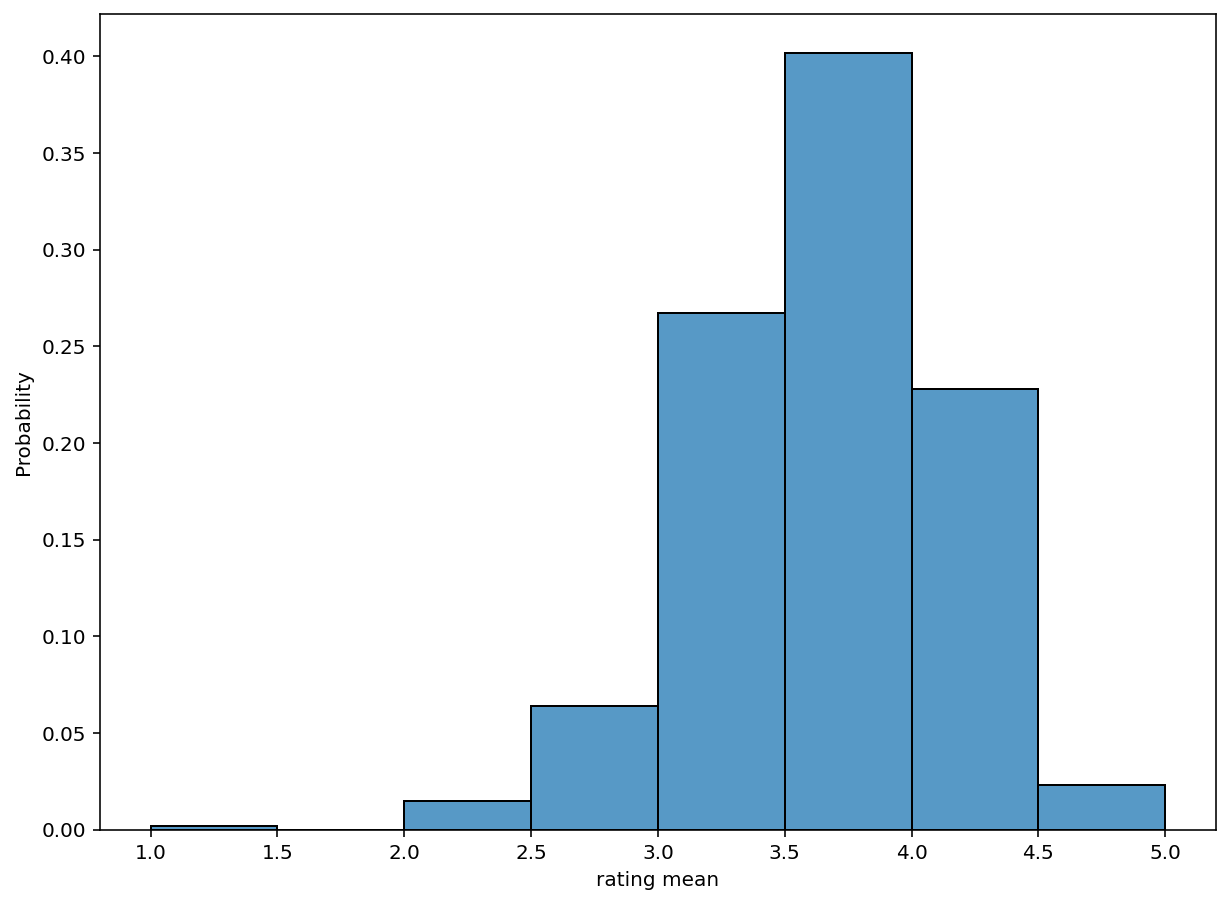

In [101]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=users, x='rating mean', binwidth=0.5, binrange=(1,5), stat="probability")
None

대부분의 사용자들이 긍정적인 평가를 주고있다.

### 2단계 평가 시스템 시각화 (넷플릭스)

넷플릭스의 평가 시스템으로 변환 했을때는 극단적인 수의 사용자가 긍정적인 평균점수를 준다

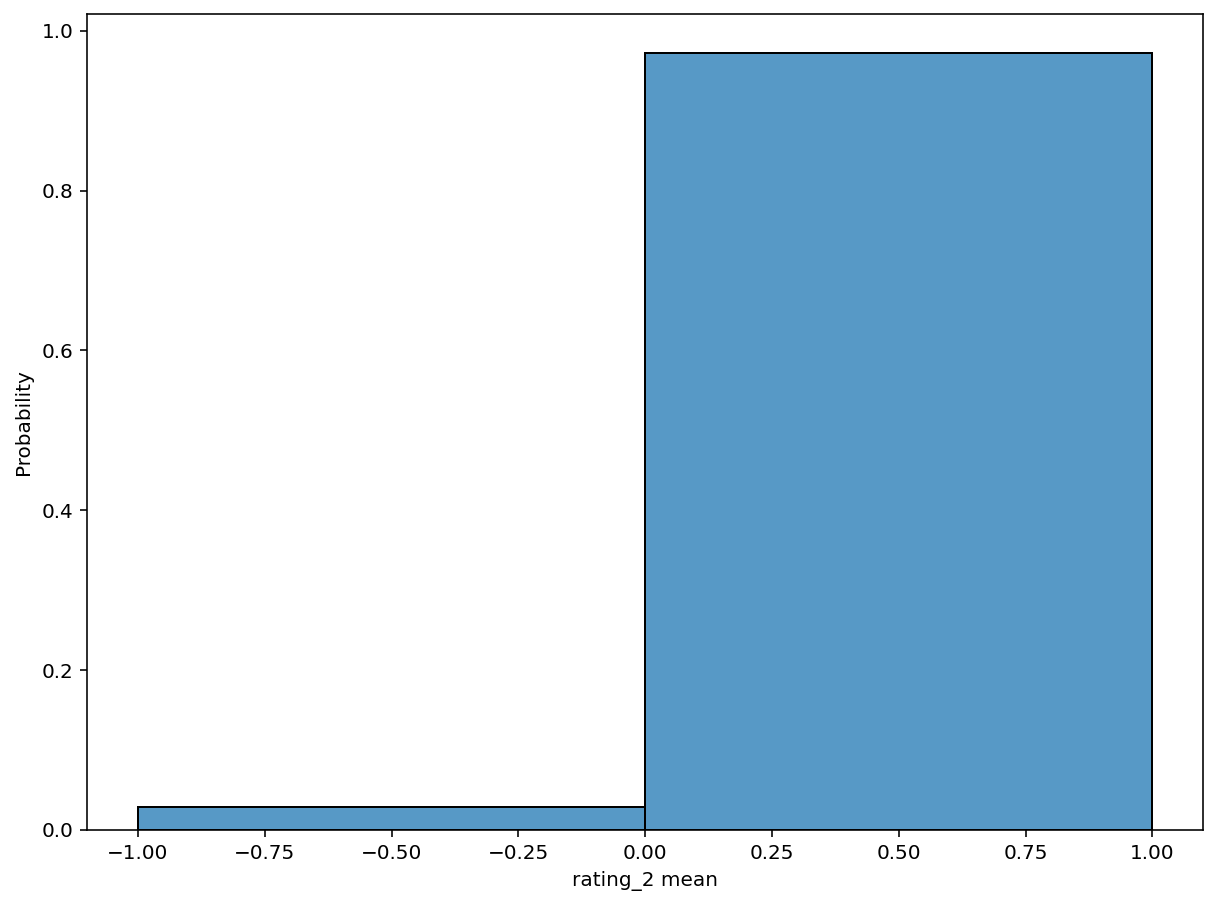

In [102]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=users, x='rating_2 mean', binwidth=1, binrange=(-1,1), stat="probability")
None

### 3단계 평가 시스템

5점 만점 평가시스템을 새로운 평가시스템으로 변환하면, 65%정도의 사용자는 평균적으로 긍정적인 평가를 내리고 35% 정도의 사용자들은 부정적인 평가를 한다.


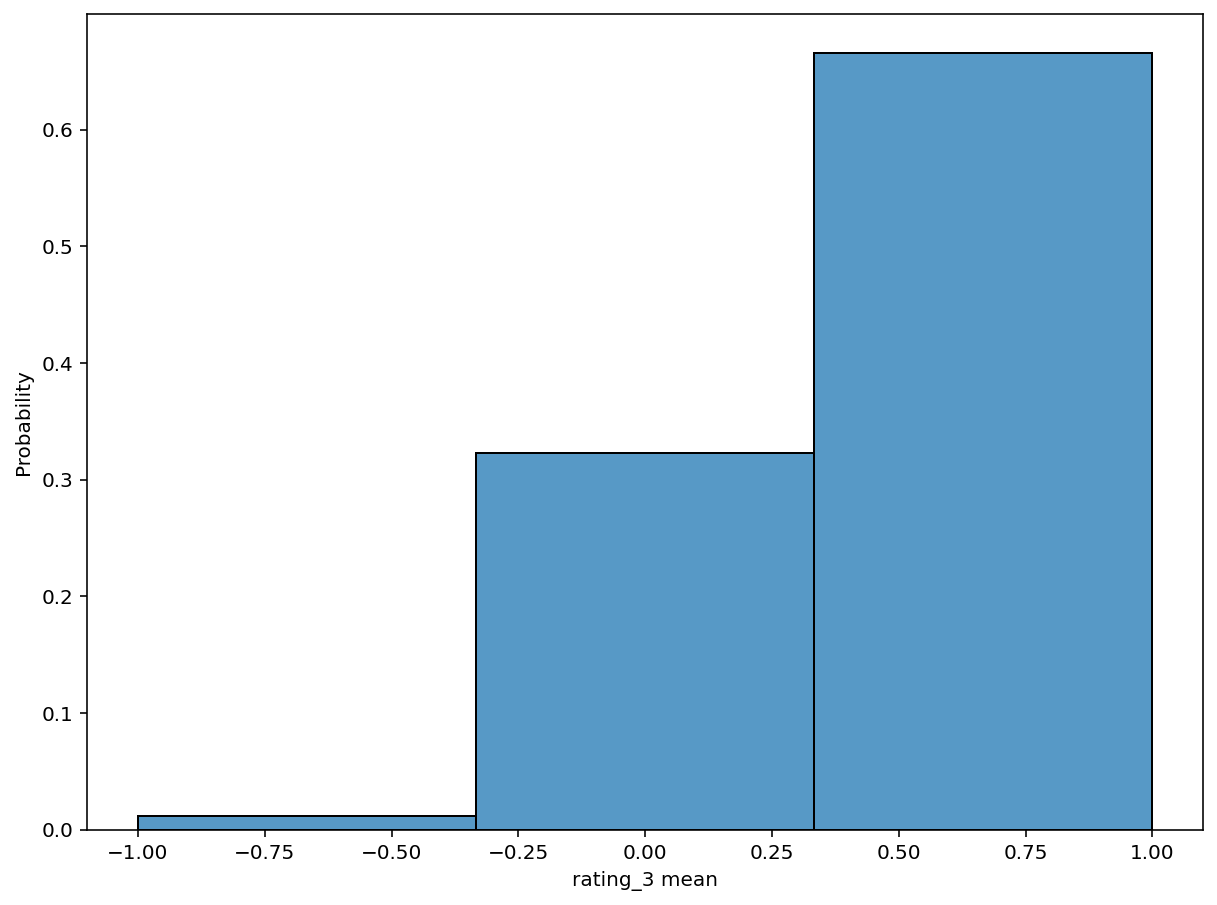

In [16]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=users, x='rating_3 mean', binwidth=(2/3), binrange=(-1,1), stat="probability")
None

## 1-1) Movies Dataset


In [17]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


title에 영화의 개봉연도가 포함되어 있다. 개봉년도를 추츨하여 새로운 column에 저장.

In [18]:
# 타이틀에서 ')' 으로 끝나는 4자리 숫자를 추출 하여 year column에 저장.
movies['year'] = movies['title'].str.extract(r"(\d{4}\))$")

# year column에 있는 ')'를 모두 제거
movies['year'] = movies['year'].str.replace(')', '')

<ipython-input-18-86c70602f5c0>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies['year'] = movies['year'].str.replace(')', '')


In [19]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   year     9719 non-null   object
dtypes: int64(1), object(3)
memory usage: 304.6+ KB


In [20]:
# 결측치 확인
movies['year'].isnull().sum()

# 23개의 영화가 year값을 가지고 있지 않다

23

In [21]:
# 개봉년도가 없는 영화들은 (결측치) 임의로 0이라는 값을 부여
movies['year'] = movies['year'].fillna(0)

In [22]:
movies['year'] = movies['year'].astype(int)

영화의 장르가 하나의 column에 저장된것을 one-hot으로 변형한다.

In [23]:
# https://stackoverflow.com/questions/50523537/one-hot-encoding-with-multiple-tags-in-the-column
genres_onehot = movies['genres'].str.get_dummies('|')
genres_onehot

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# 위에서 one_hot으로 인코딩 장르를 기존의 movies에 합쳐준다.
movies = pd.merge(movies, genres_onehot, left_index=True, right_index=True)

In [25]:
movies

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,2017,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
movie_ratings = ratings.groupby('movieId', as_index=False).agg({'rating': ['count', 'mean'],'rating_2':'mean', 'rating_3':'mean'})

# hierarchical columns Flatten
movie_ratings.columns = [' '.join(col).strip() for col in movie_ratings]

In [103]:
movie_ratings = movies.merge(movie_ratings, on='movieId')
movie_ratings.drop(labels=['genres', 'year', '(no genres listed)', 'Action', 'Adventure','Animation','Children','Comedy','Mystery','Romance','Sci-Fi','Thriller', 'War', 'Western'])

KeyError: "['genres' 'year' '(no genres listed)' 'Action' 'Adventure' 'Animation'\n 'Children' 'Comedy' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War'\n 'Western'] not found in axis"

In [28]:
# 각 영화가 평가 받은 횟수 분포
movie_ratings['rating count'].describe()

count   9724.00
mean      10.37
std       22.40
min        1.00
25%        1.00
50%        3.00
75%        9.00
max      329.00
Name: rating count, dtype: float64

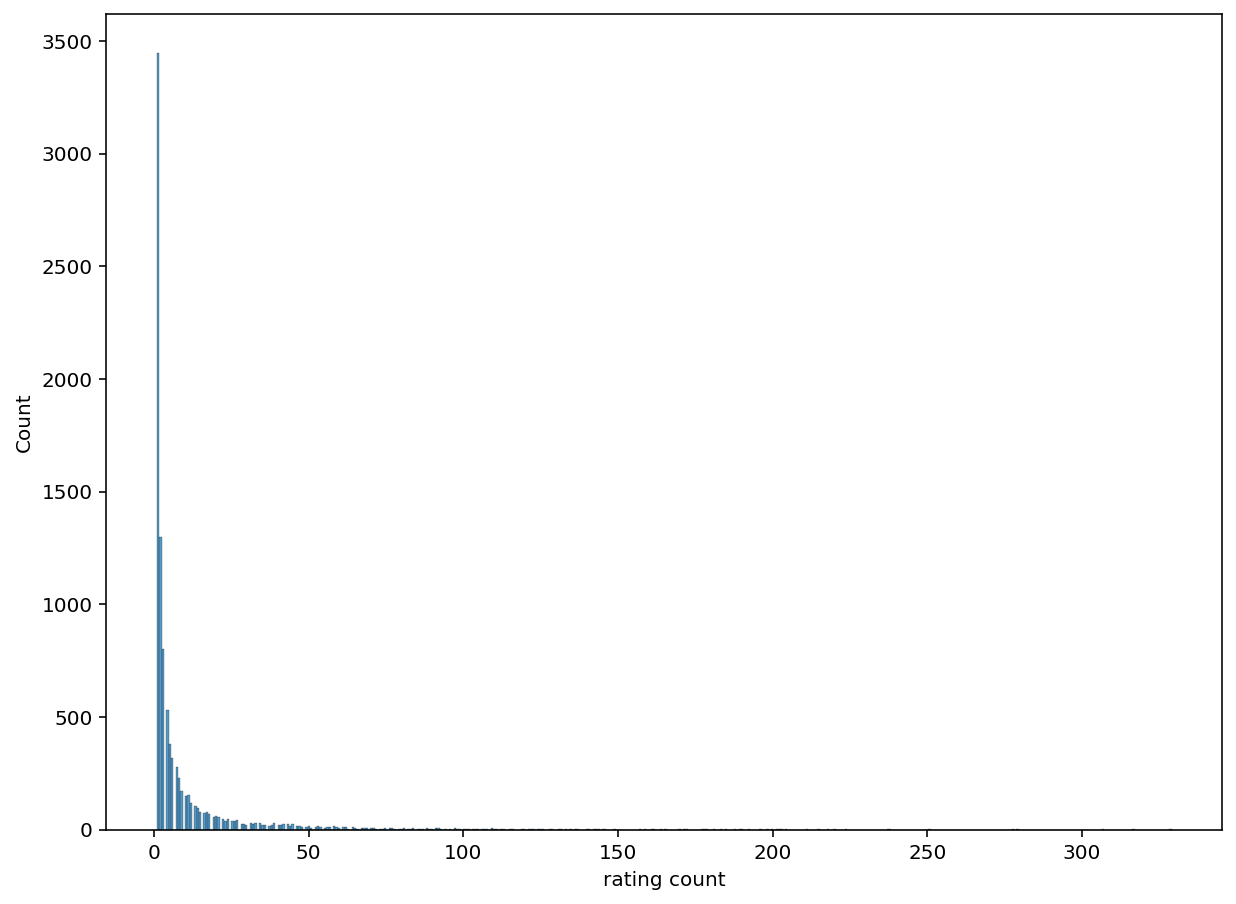

In [29]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=movie_ratings, x='rating count')
# plt.xticks(rotation=90)
None

위의 그래프는

9724개의 

- 평균 10.37번의 평가를 받음
- 한 영화가 최고로 많은 평가를 받은 횟수는 329번
- 가장 적은 평가를 받은 횟수는 1번
- 50% (median) 값은 3

적은 수의 평가를 받은 영화의 평균 평점은 많은 수의 평점을 받은 영화의 평점보다 신뢰도가 낮다.

적은 수의 평가를 받은 영화데이터를 모델 생성에 포함하면 부정확한 모델을 생성 할 수 있기 때문에 임의로 15번 이하의 평가를 받은 영화는 제거

In [30]:
movie_ratings_5up = movie_ratings[movie_ratings['rating count'] > 15]

In [31]:
movie_ratings_5up.shape

(1572, 28)

In [32]:
1572/9724

0.1616618675442205

6번 이상의 평가를 받은 영화는 9624개중 3268개 이다. 영화 데이터 중에서 (16%)정도만 사용
- (그렇지만, 더 많은 수의 사용자 리뷰를 가지고 있다)

In [33]:
movie_ratings_5up.sort_values('rating mean', ascending=False).head(5)

,movieId,title,genres,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating count,rating mean,rating_2 mean,rating_3 mean
840,1104,"Streetcar Named Desire, A (1951)",Drama,1951,0,0,0,0,0,0,...,0,0,0,0,0,0,20,4.47,1.00,0.90
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,1994,0,0,0,0,0,0,...,0,0,0,0,0,0,317,4.43,0.97,0.85
704,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,1950,0,0,0,0,0,0,...,0,1,0,0,0,0,27,4.33,0.93,0.89
2589,3468,"Hustler, The (1961)",Drama,1961,0,0,0,0,0,0,...,0,0,0,0,0,0,18,4.33,1.00,0.78
2565,3435,Double Indemnity (1944),Crime|Drama|Film-Noir,1944,0,0,0,0,0,0,...,0,0,0,0,0,0,17,4.32,0.88,0.88


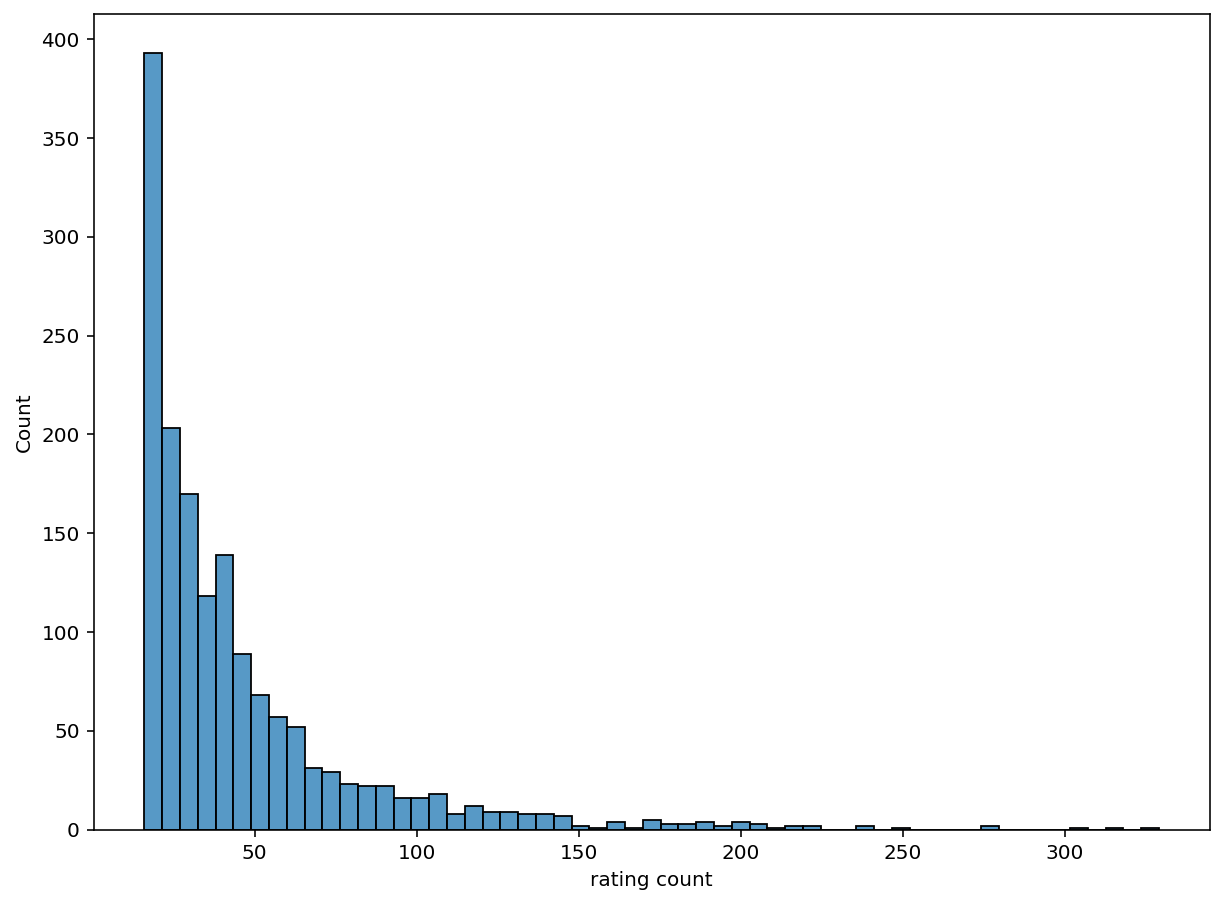

In [34]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=movie_ratings_5up, x='rating count')
# plt.xticks(rotation=90)
None

## 영화의 평균평점 분포도

아래 그래프들은 15번 이상의 평점을 받은 **영화 평균 평점**을 나타낸것이다.

### 5점 만점 평가 시각화 (15번 이상의 평점을 받은 영화)
대체적으로 많은 수의 영화가 긍정 평가를 받음

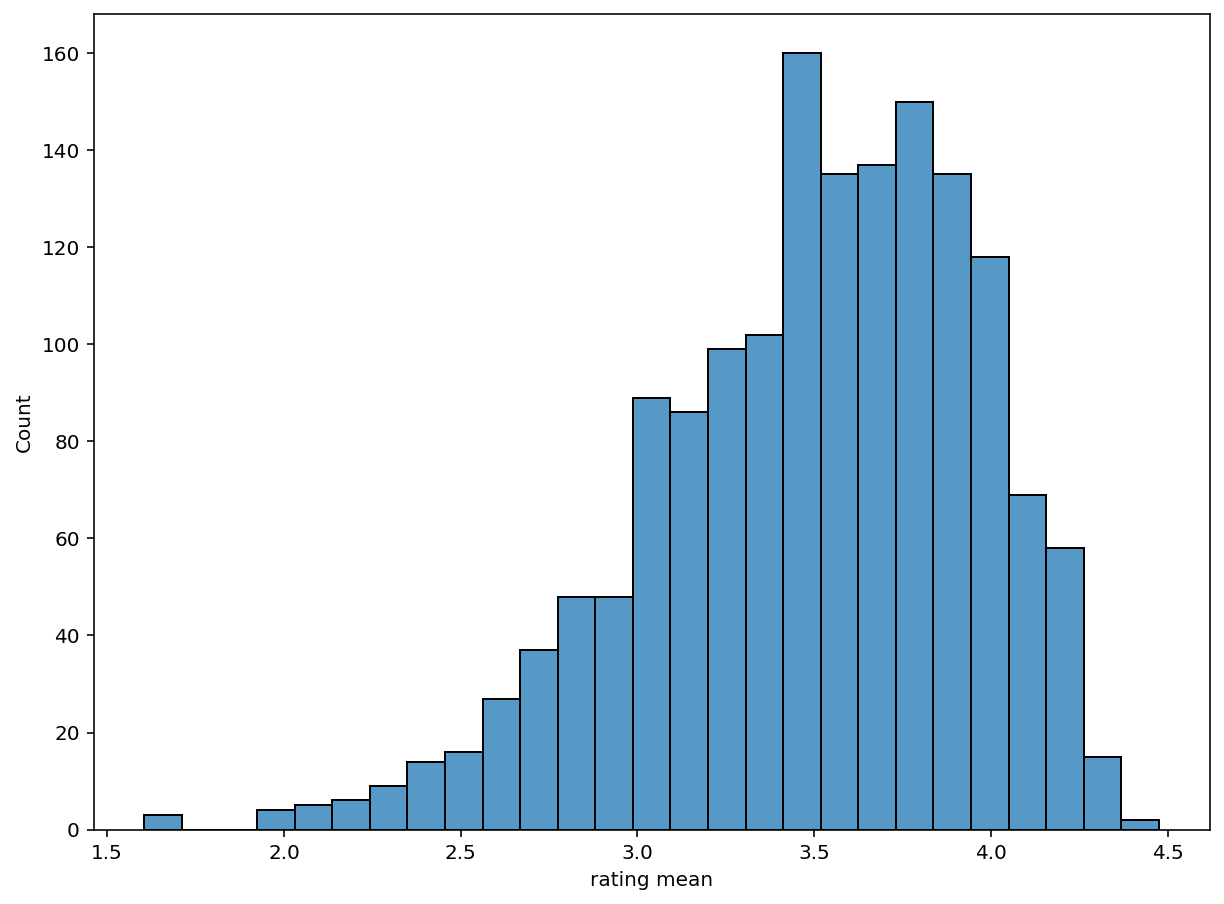

In [35]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=movie_ratings_5up, x='rating mean')
# plt.xticks(rotation=90)
None

### 2단계 평가 시스템 시각화 (넷플릭스) - (15번 이상의 평점을 받은 영화)

2단계 평가 시스템으로 변환 했을때 대부분의 영화가 긍정적인 평균점수를 받음.

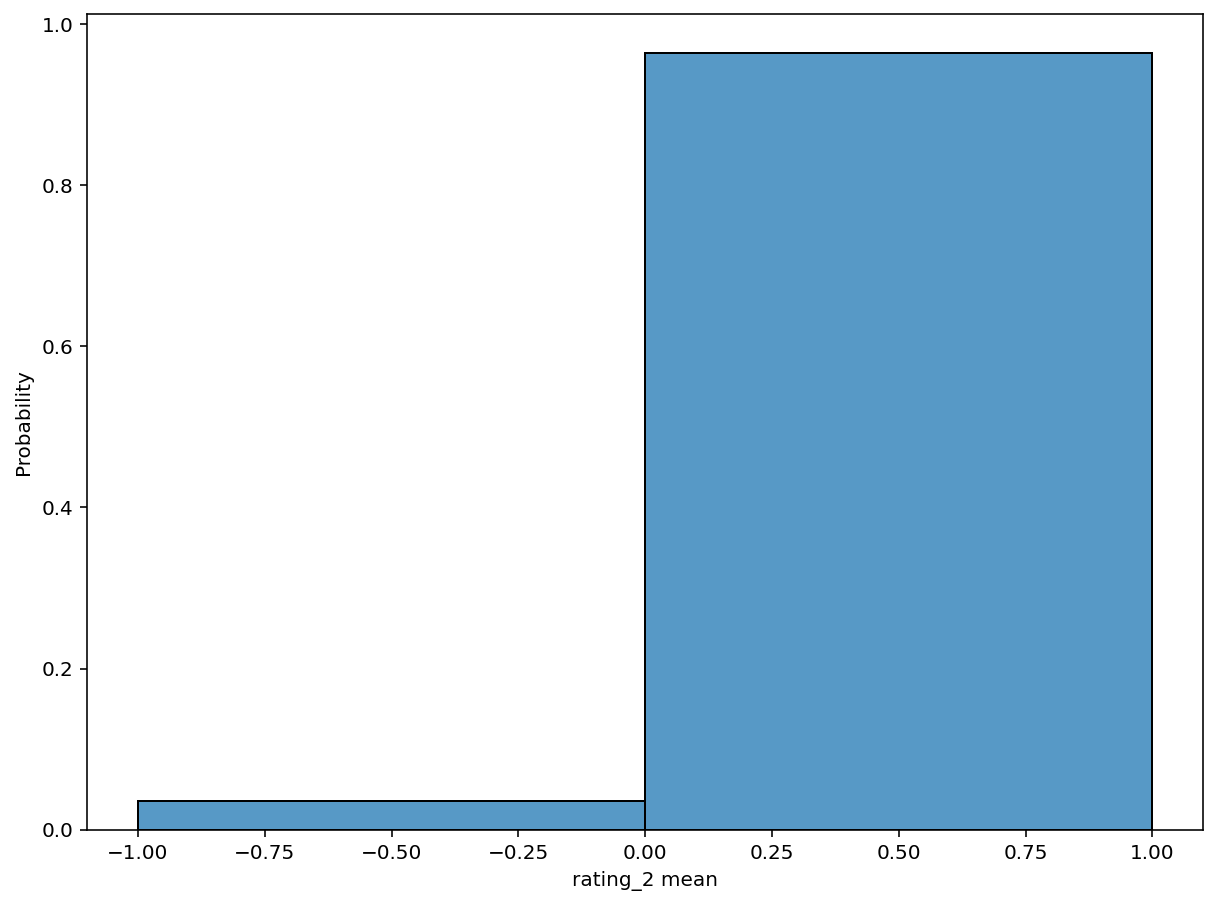

In [36]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=movie_ratings_5up, x='rating_2 mean', binwidth=1, binrange=(-1,1), stat="probability")
# plt.xticks(rotation=90)
None

### 3단계 평가 시스템 - (15번 이상의 평점을 받은 영화)

- 60% 정도의 영화는 긍정적인 평가를 받음
- 39% 정도의 영화가 보통 평가를 받음
- 1% 정도의 영화는 부정적인 평가를 받음

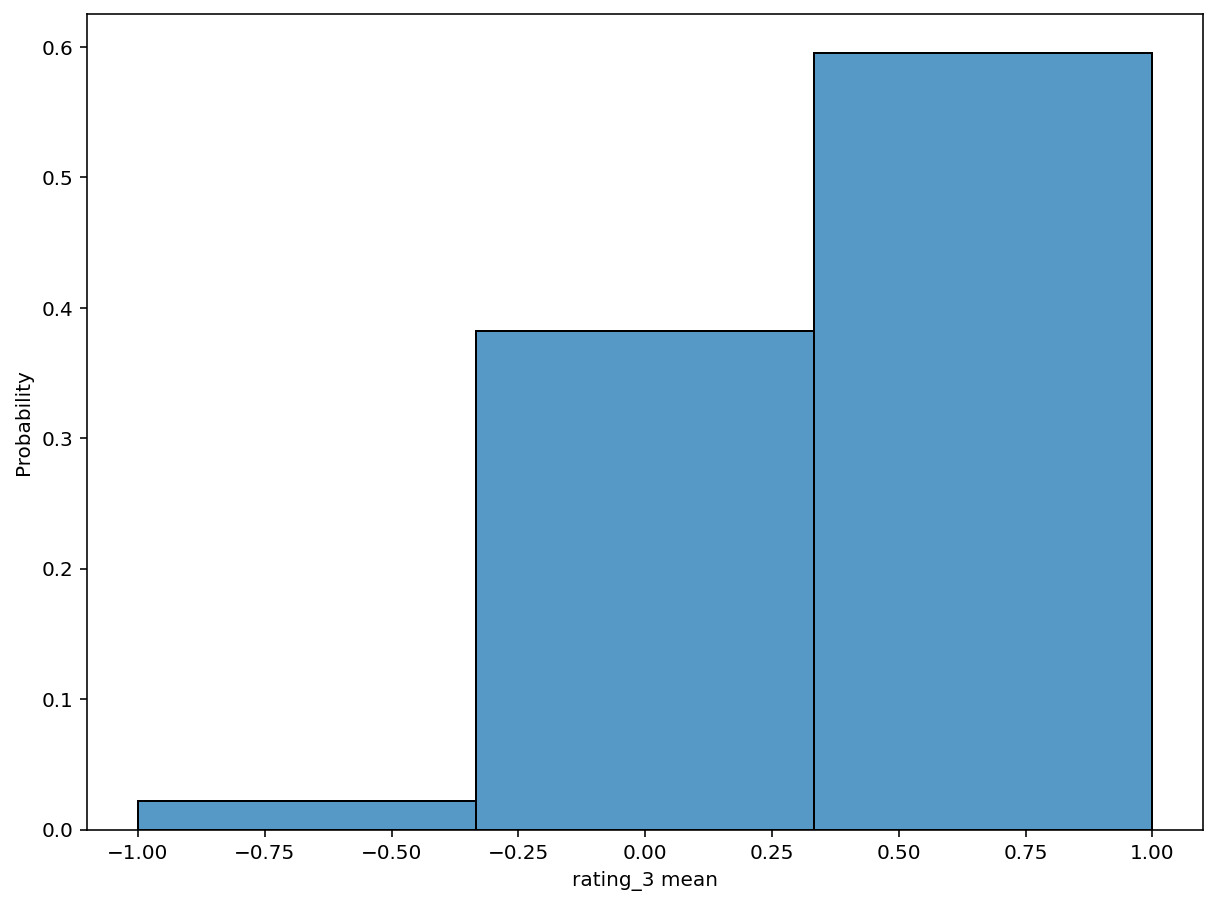

In [37]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=movie_ratings_5up, x='rating_3 mean', binwidth=(2/3), binrange=(-1,1), stat="probability")
# plt.xticks(rotation=90)
None

In [38]:
ratings

,userId,movieId,rating,timestamp,rating_2,rating_3
0,1,1,4.00,964982703,1.00,1.00
1,1,3,4.00,964981247,1.00,1.00
2,1,6,4.00,964982224,1.00,1.00
3,1,47,5.00,964983815,1.00,1.00
4,1,50,5.00,964982931,1.00,1.00
...,...,...,...,...,...,...
100831,610,166534,4.00,1493848402,1.00,1.00
100832,610,168248,5.00,1493850091,1.00,1.00
100833,610,168250,5.00,1494273047,1.00,1.00
100834,610,168252,5.00,1493846352,1.00,1.00


# Model 구현

## 2) Model - Baseline KNN

In [39]:
# 필요한 패키지 불러오기 
from surprise import NormalPredictor, KNNBasic,SVD, SVDpp
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

ramdom_state = 63

In [40]:
# Score Scale
reader = Reader(rating_scale=(0.5, 5))
reader_2_3 = Reader(rating_scale=(-1, 1))

# dataset for Rating System
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data_2 = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating_2']], reader_2_3)
data_3 = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating_3']], reader_2_3)


### 알고리즘 비교

리뷰 시스템들간의 성능을 비교하기전에 5점만점 리뷰시스템을 사용하여 추천모델 알고리즘들의 성능을 먼저 비교 하도록 한다. (RMSE로 각 알고리즘의 성능을 비교)

**Normal Predictor**는 사용자들의 평점분포를 기반하여 예측하는 알고리즘. (Baseline 기준점)

**KNN Basic** 은 **k-nearest neighbors**을 활용하는 기본 알고리즘 (cosine similarity를 사용하여 아이템과 아이템간의 유사성을 찾음)

**SVD (Singular Value Decomposition)** 은 **Matrix Factorization**(행렬 인수 분해)방법중의 하나로
m 명의 사용자와 n개의 아이템을 m x n 형태의 R로 나타낸 Matrix를 분해하여, 사용자의 정보만 가지고있는 U = (m x m) 와 아이템의 정보를 가지고 있는 V = (n x n) 그리고 **특이값을** 가진 대각 행렬 Σ = (m x n)을 **추출**하는 알고리즘이다.



In [41]:
reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

sim_options = {'name': 'cosine','user_based': False}

benchmark =[]

for algorithm in [NormalPredictor(), KNNBasic(sim_options=sim_options), SVD(random_state=ramdom_state)]:
    results = cross_validate(algorithm, data, cv=5, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    temp = temp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(temp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.87,0.67,2.22,0.07
KNNBasic,0.98,0.76,5.87,2.64
NormalPredictor,1.43,1.14,0.04,0.06


위의 결과를 보았을때 (RMSE가 0에 가까울수록 예측성능이 뛰어남)

- SVD 알리고리즘이 RMSE : 0.87로 가장 좋은 성능을

- KNN Basic 알고리즘 RMSE : 0.98

- Normal Predictor 알고리즘은 RMSE : 1.42 로 가장 낮을 성능을 보여주었다.

이후 추천 시스템의 성능비교는 예측성능이 가장 좋았던 SVD 알고리즘을 사용하여 비교

### SVD Model (Matrix Factorization Model)

In [42]:
#set seed
ramdom_state=63

# Score Scale
reader = Reader(rating_scale=(0.5, 5))
reader_2_3 = Reader(rating_scale=(-1, 1))

# dataset for Rating System
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data_2 = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating_2']], reader_2_3)
data_3 = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating_3']], reader_2_3)


# 5점 만점
trainset, testset = train_test_split(data, test_size=.25, random_state=ramdom_state)

algo = SVD(random_state=ramdom_state)
algo.fit(trainset)

print('5점 만점 평가시스템') 
predictions = algo.test(testset)
accuracy.rmse(predictions)



# 2단계 리뷰 시스템
trainset_2, testset_2 = train_test_split(data_2, test_size=.25, random_state=ramdom_state)

algo.fit(trainset_2)
predictions_2 = algo.test(testset_2)

print('\n2단계 평가시스템')
accuracy.rmse(predictions_2)


# 3단계
trainset_3, testset_3 = train_test_split(data_3, test_size=.25, random_state=ramdom_state)

algo = SVD(random_state=ramdom_state)

algo.fit(trainset_3)
predictions_3 = algo.test(testset_3)

print('\n3단계 평가시스템')
accuracy.rmse(predictions_3)

5점 만점 평가시스템
RMSE: 0.8749

2단계 평가시스템
RMSE: 0.7051

3단계 평가시스템
RMSE: 0.6076


0.6075643515861395

SVD 알고리즘을 사용 했을때 

5점 만점 리뷰시스템의 성능은 RMSE는 0.8749

2단계 (넷플릭스) ('좋아요'/'싫어요') 리뷰 시스템의 RMSE는 0.7051

3단계 (New) ('좋아요','보통이에요','싫어요') 리뷰 시스템의 RMSE는 0.6076

**결과:** SVD 알고리즘을 사용한 새로운 3단계 리뷰시스템의 예측성능이 가장 좋다.

## Cross Validation을 사용하여 성능 비교 (CV = 7)

### 5점만점 리뷰시스템 (넷플릭스) - RMSE 평균 : 0.8708

In [43]:
# CV 7
cross_validate(SVD(random_state=ramdom_state), data, cv=7, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    0.8694  0.8717  0.8666  0.8665  0.8752  0.8712  0.8607  0.8687  0.0043  
MAE (testset)     0.6675  0.6664  0.6664  0.6672  0.6720  0.6705  0.6638  0.6677  0.0025  
Fit time          2.38    2.39    2.38    2.38    2.74    2.52    2.46    2.46    0.12    
Test time         0.03    0.11    0.03    0.03    0.11    0.04    0.04    0.06    0.03    


{'test_rmse': array([0.86938169, 0.87165664, 0.8665564 , 0.86647185, 0.87515778,
        0.87123512, 0.86066974]),
 'test_mae': array([0.66750888, 0.66644345, 0.66636924, 0.66717216, 0.67197805,
        0.67046367, 0.66383689]),
 'fit_time': (2.382622241973877,
  2.3865270614624023,
  2.378031015396118,
  2.3779380321502686,
  2.7403221130371094,
  2.5167078971862793,
  2.464884042739868),
 'test_time': (0.034111976623535156,
  0.1068868637084961,
  0.03420686721801758,
  0.03405499458312988,
  0.11387801170349121,
  0.03643321990966797,
  0.03574490547180176)}

### 2단계 리뷰시스템 (넷플릭스) - RMSE 평균 : 0.7065

In [44]:
cross_validate(SVD(random_state=ramdom_state), data_2, cv=7, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    0.7066  0.7109  0.7078  0.7078  0.7043  0.7053  0.7015  0.7063  0.0028  
MAE (testset)     0.4983  0.5026  0.5018  0.4989  0.4987  0.4991  0.4958  0.4993  0.0021  
Fit time          2.41    2.44    2.39    2.38    2.38    2.39    2.38    2.40    0.02    
Test time         0.04    0.04    0.03    0.03    0.11    0.03    0.04    0.05    0.03    


{'test_rmse': array([0.70661925, 0.7109071 , 0.70783008, 0.70778068, 0.70429648,
        0.70528135, 0.70148433]),
 'test_mae': array([0.49834118, 0.50262738, 0.50183954, 0.49894553, 0.49866133,
        0.49910422, 0.49583643]),
 'fit_time': (2.4084060192108154,
  2.439755916595459,
  2.389415979385376,
  2.378023862838745,
  2.3812408447265625,
  2.3908767700195312,
  2.3798229694366455),
 'test_time': (0.037368059158325195,
  0.0356900691986084,
  0.03481888771057129,
  0.03461003303527832,
  0.10874700546264648,
  0.03471183776855469,
  0.035260915756225586)}

### 3단계 리뷰시스템 - New - RMSE 평균 : 0.6058

In [45]:
cross_validate(SVD(random_state=ramdom_state), data_3, cv=7, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    0.6064  0.6086  0.6138  0.6059  0.6090  0.6070  0.5978  0.6069  0.0045  
MAE (testset)     0.4925  0.4941  0.4963  0.4922  0.4941  0.4918  0.4846  0.4922  0.0034  
Fit time          2.39    2.38    2.41    2.45    2.42    2.41    2.40    2.41    0.02    
Test time         0.04    0.04    0.03    0.03    0.11    0.04    0.04    0.05    0.03    


{'test_rmse': array([0.60640467, 0.60863758, 0.61380237, 0.60589947, 0.60897069,
        0.6069707 , 0.59777495]),
 'test_mae': array([0.49248522, 0.49405161, 0.49629729, 0.49223574, 0.49412716,
        0.49177919, 0.4846326 ]),
 'fit_time': (2.393152952194214,
  2.3846912384033203,
  2.4066760540008545,
  2.4500069618225098,
  2.416882038116455,
  2.4127609729766846,
  2.3985798358917236),
 'test_time': (0.0382390022277832,
  0.03533601760864258,
  0.03499007225036621,
  0.034944772720336914,
  0.11016106605529785,
  0.035093069076538086,
  0.03511810302734375)}

# Prediction 결과 확인 

아래 코드 [출처](https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb)

### 5점 만점 리뷰 시스템

In [46]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user. 유저의 실제 ID
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item. 아이템/영화의 실제 ID
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['UserId', 'MovieId', 'UserRating', 'Predicted','details'])
df = df.drop(axis=1, labels='details')
df['# of reviews User Gave'] = df.UserId.apply(get_Iu) # 유저가 영화를 평가한 횟수.
df['# of reviews received (Movie)'] = df.MovieId.apply(get_Ui) # 영화가 리뷰를 받은 횟수
df['err'] = abs(df.Predicted - df.UserRating) # 예측값과 실제값의 차이

In [47]:
df

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
0,166,2628,3.50,3.25,150,102,0.25
1,599,1982,3.00,2.60,1889,18,0.40
2,260,6375,3.50,3.46,109,0,0.04
3,380,7845,4.00,3.45,911,3,0.55
4,249,114074,4.00,3.63,792,2,0.37
...,...,...,...,...,...,...,...
25204,19,541,4.00,3.43,539,93,0.57
25205,178,349,4.00,3.89,48,80,0.11
25206,223,32587,4.00,3.39,55,60,0.61
25207,68,56174,3.50,3.40,956,51,0.10


In [48]:
# 실제 유저의 평가점수와, 모델이 예측한 점수의 오차로
# 좋은 예측이었는지, 나쁜 예측이었는지 구분

best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err',ascending=False)[:10]

In [49]:
filt = movie_ratings.filter(items=['title', 'movieId', 'rating mean'])

In [50]:
best_predictions

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
24542,452,4002,5.00,5.00,151,20,0.00
2919,543,2571,5.00,5.00,64,200,0.00
11546,543,4226,5.00,5.00,64,120,0.00
14919,171,1104,5.00,5.00,61,13,0.00
14850,543,60069,5.00,5.00,64,72,0.00
1510,452,356,5.00,5.00,151,233,0.00
14831,452,1198,5.00,5.00,151,147,0.00
14664,400,296,5.00,5.00,29,216,0.00
22175,171,720,5.00,5.00,61,19,0.00
13095,1,527,5.00,5.00,180,166,0.00


### 최고의 추천 분석

대부분의 영화들이 10번이상의 리뷰를 받았고.
사용자의 평점과 예측된 평점의 차이('err')가 0 이기 때문에. 사용자에게 알 맞는 예측을 했다고 볼 수 있다.

영화들 또한 10번 이상의 평점을 받고 , 평점평균이 4점을 넘는 대채적으로 긍정적인 평가를 받는 영화들이다.

In [51]:
best_predictions.merge(filt, left_on='MovieId', right_on='movieId').drop(axis=1, labels='movieId')

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err,title,rating mean
0,452,4002,5.00,5.00,151,20,0.00,"Planes, Trains & Automobiles (1987)",3.85
1,543,2571,5.00,5.00,64,200,0.00,"Matrix, The (1999)",4.19
2,543,4226,5.00,5.00,64,120,0.00,Memento (2000),4.12
3,171,1104,5.00,5.00,61,13,0.00,"Streetcar Named Desire, A (1951)",4.47
4,543,60069,5.00,5.00,64,72,0.00,WALL·E (2008),4.06
5,452,356,5.00,5.00,151,233,0.00,Forrest Gump (1994),4.16
6,452,1198,5.00,5.00,151,147,0.00,Raiders of the Lost Ark (Indiana Jones and the...,4.21
7,400,296,5.00,5.00,29,216,0.00,Pulp Fiction (1994),4.20
8,171,720,5.00,5.00,61,19,0.00,Wallace & Gromit: The Best of Aardman Animatio...,4.09
9,1,527,5.00,5.00,180,166,0.00,Schindler's List (1993),4.22


In [52]:
worst_predictions.merge(filt, left_on='MovieId', right_on='movieId').drop(axis=1, labels='movieId')

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err,title,rating mean
0,441,527,0.50,5.00,34,166,4.50,Schindler's List (1993),4.22
1,256,5618,0.50,4.95,125,64,4.45,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.16
2,105,4027,0.50,4.40,550,70,3.90,"O Brother, Where Art Thou? (2000)",3.81
3,413,1198,1.00,4.84,42,147,3.84,Raiders of the Lost Ark (Indiana Jones and the...,4.21
4,51,3253,0.50,4.29,259,44,3.79,Wayne's World (1992),3.48
5,522,106100,0.50,4.29,152,14,3.79,Dallas Buyers Club (2013),3.97
6,125,4973,0.50,4.24,269,88,3.74,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.18
7,594,6639,0.50,4.17,169,4,3.67,Wait Until Dark (1967),3.43
8,399,2858,0.50,4.12,28,159,3.62,American Beauty (1999),4.06
9,594,4517,0.50,4.11,169,1,3.61,Lady in White (a.k.a. The Mystery of the Lady ...,1.75


### 최악의 추천 분석

대체적으로 쉰들러 리스트, 센과 치히로의 행방불명, 인디아나 존스, 아멜리아, 아메리칸 뷰티 이 다섯가지 영화는 평균 평점 4 이상과 60번이 넘는 많은 리뷰를 받았지만.

대체적으로 441, 256, 413, 125, 399들은 각 영화에 아주 낮은 점수를 부여 하였다.


In [53]:
users[users['userId']==441]

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
440,441,45,4.52,0.96,0.89


In [54]:
users[users['userId']==256]

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
255,256,174,3.95,0.93,0.72


In [55]:
users[users['userId']==413]

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
412,413,56,4.41,0.79,0.75


In [56]:
users[users['userId']==125]

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
124,125,360,3.86,0.82,0.60


In [57]:
users[users['userId']==399]

,userId,rating count,rating mean,rating_2 mean,rating_3 mean
398,399,36,3.94,0.72,0.58


위에서 사용자들의 영화에 준 평균 평점을 확인해 보면('rating mean'), 사용자 모두가 대체적으로 긍정적인 평가를 주고 있다.

#### 이로써 알 수 있는 사실은

현재의 추천 모델은 사용자의 취향을 반영하지 못한 모델이라고 생각 할 수 있다.

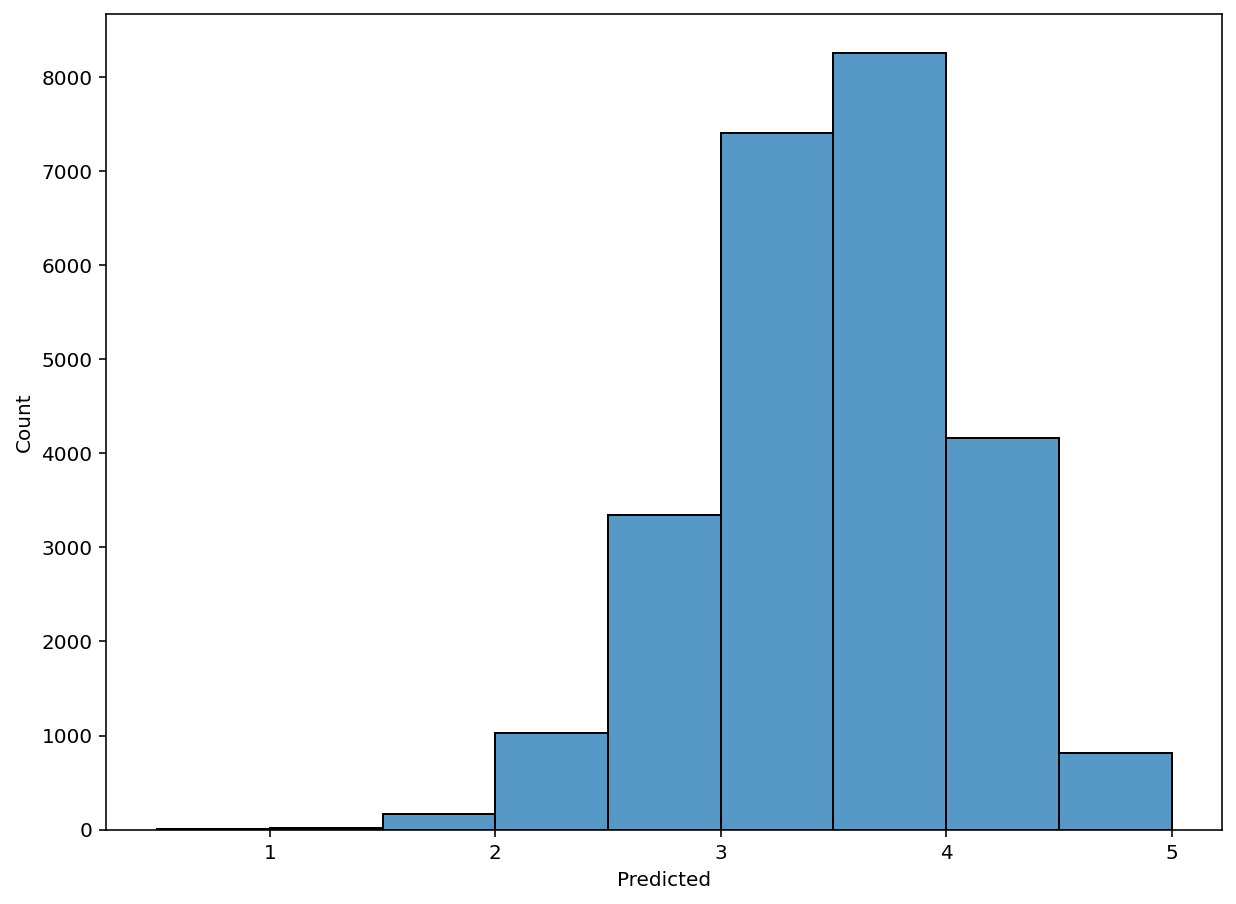

In [58]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df, x='Predicted', binwidth=0.5, binrange=(0.5,5), stat="count")
None

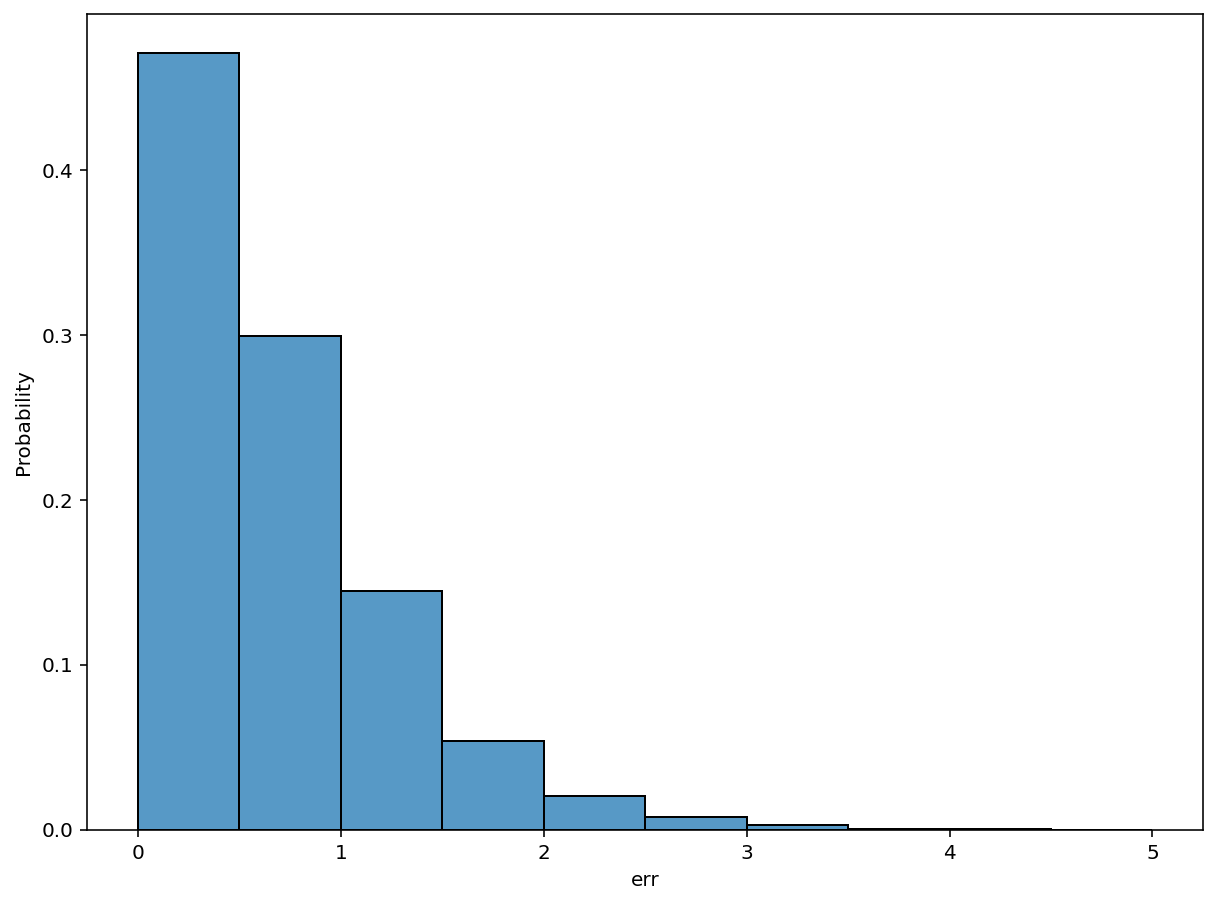

In [59]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df, x='err',binwidth=(0.5), binrange=(0,5), stat="probability")
None

## Classification

Prediction 값을 0.5 단위로 변환

x = Prediction 일때 

- x < 0.75 일때 0.5 으로 변환
- 0.75 < x < 1.25 일때 1.0 으로 변환
- 1.25 < x < 1.75 일때 1.5 으로 변환
- 1.75 < x < 2.25 일때 2.0 으로 변환
- 2.25 < x < 2.75 일때 2.5 으로 변환
- 2.75 < x < 3.25 일때 3.0 으로 변환
- 3.25 < x < 3.75 일때 3.5 으로 변환
- 3.75 < x < 4.25 일때 4.0 으로 변환
- 4.25 < x < 4.75 일때 4.5 으로 변환
- x > 4.75 일때 5.0 으로 변환

In [60]:
df_1_edited = df.copy()
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x < 0.75, (0.5),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 0.75 and x < 1.25, (1),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 1.25 and x < 1.75, (1.5),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 1.75 and x < 2.25, (2),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 2.25 and x < 2.75, (2.5),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 2.75 and x < 3.25, (3),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 3.25 and x < 3.75, (3.5),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 3.75 and x < 4.25, (4),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 4.25 and x < 4.75, (4.5),x))
df_1_edited['Predicted']=df_1_edited['Predicted'].apply(lambda x: np.where(x > 4.75,(5), x))
df_1_edited['err'] = abs(df_1_edited.Predicted - df_1_edited.UserRating) # 예측값과 실제값의 차이
df_1_edited

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
0,166,2628,3.50,3.00,150,102,0.50
1,599,1982,3.00,2.50,1889,18,0.50
2,260,6375,3.50,3.50,109,0,0.00
3,380,7845,4.00,3.50,911,3,0.50
4,249,114074,4.00,3.50,792,2,0.50
...,...,...,...,...,...,...,...
25204,19,541,4.00,3.50,539,93,0.50
25205,178,349,4.00,4.00,48,80,0.00
25206,223,32587,4.00,3.50,55,60,0.50
25207,68,56174,3.50,3.50,956,51,0.00


In [61]:
df_1_edited.Predicted.value_counts()

3.50    8814
4.00    6438
3.00    5159
4.50    2090
2.50    1961
2.00     478
5.00     212
1.50      51
1.00       6
Name: Predicted, dtype: int64

In [62]:
from sklearn.metrics import confusion_matrix

y_true = df_1_edited['UserRating'].astype('str')
y_pred = df_1_edited['Predicted'].astype('str')

In [63]:
y_pred.shape

(25209,)

In [64]:
cm = confusion_matrix(y_true, y_pred, labels=['0.5','1.0', '1.5', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])

In [65]:
cm_df = pd.DataFrame(cm, columns = ['0.5','1.0', '1.5', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'], index = ['0.5','1.0', '1.5', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])

cm_df

,0.5,1.0,1.5,2.5,3.0,3.5,4.0,4.5,5.0
0.5,0,4,9,95,87,58,28,3,2
1.0,0,0,15,163,226,148,50,4,1
1.5,0,1,8,126,167,86,24,0,0
2.5,0,1,4,295,521,368,127,18,2
3.0,0,0,6,477,1501,1936,779,114,7
3.5,0,0,0,175,733,1518,727,133,4
4.0,0,0,1,150,908,2712,2291,584,38
4.5,0,0,0,21,167,673,899,416,21
5.0,0,0,1,34,171,803,1376,789,135


In [66]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, labels=['1.0', '1.5', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       691
         1.5       0.16      0.02      0.03       455
         2.5       0.15      0.21      0.18      1395
         3.0       0.29      0.31      0.30      4900
         3.5       0.17      0.46      0.25      3311
         4.0       0.36      0.34      0.35      6699
         4.5       0.20      0.19      0.19      2200
         5.0       0.64      0.04      0.08      3323

   micro avg       0.25      0.27      0.26     22974
   macro avg       0.25      0.20      0.17     22974
weighted avg       0.31      0.27      0.24     22974



Classification 모델이었을 경우 5점 만점 리뷰 시스템의 정확도는 31% 로 좋은 성능을 보여주지는 않는다. 

그렇지만 사용자들이 1단계 오차를 감수 할 수 있다고 가정하여 조금 느슨한 정확도를 대입하면 68%정도의 정확도를 확보 할 수 있다.

In [67]:
1+15+8+126+4+295+521+477+1501+1936+733+1518+727+2712+2291+584+899+416+21+789+135

15709

In [68]:
15709/22974

0.6837729607382258

# 2단계 - Netflix

In [69]:
df_2 = pd.DataFrame(predictions_2, columns=['UserId', 'MovieId', 'UserRating', 'Predicted','details'])    
df_2 = df_2.drop(axis=1, labels='details')
df_2['# of reviews User Gave'] = df_2.UserId.apply(get_Iu) # 유저가 영화를 평가한 횟수.
df_2['# of reviews received (Movie)'] = df_2.MovieId.apply(get_Ui) # 영화가 리뷰를 받은 횟수
df_2['err'] = abs(df_2.Predicted - df_2.UserRating) # 예측값과 실제값의 차이

In [70]:
filt_2 = movie_ratings.filter(items=['title', 'movieId', 'rating_2 mean'])

In [71]:
df_2

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
0,166,2628,1.00,0.47,150,102,0.53
1,599,1982,1.00,-0.30,1889,18,1.30
2,260,6375,1.00,0.54,109,0,0.46
3,380,7845,1.00,0.70,911,3,0.30
4,249,114074,1.00,1.00,792,2,0.00
...,...,...,...,...,...,...,...
25204,19,541,1.00,0.35,539,93,0.65
25205,178,349,1.00,0.86,48,80,0.14
25206,223,32587,1.00,0.63,55,60,0.37
25207,68,56174,1.00,0.69,956,51,0.31


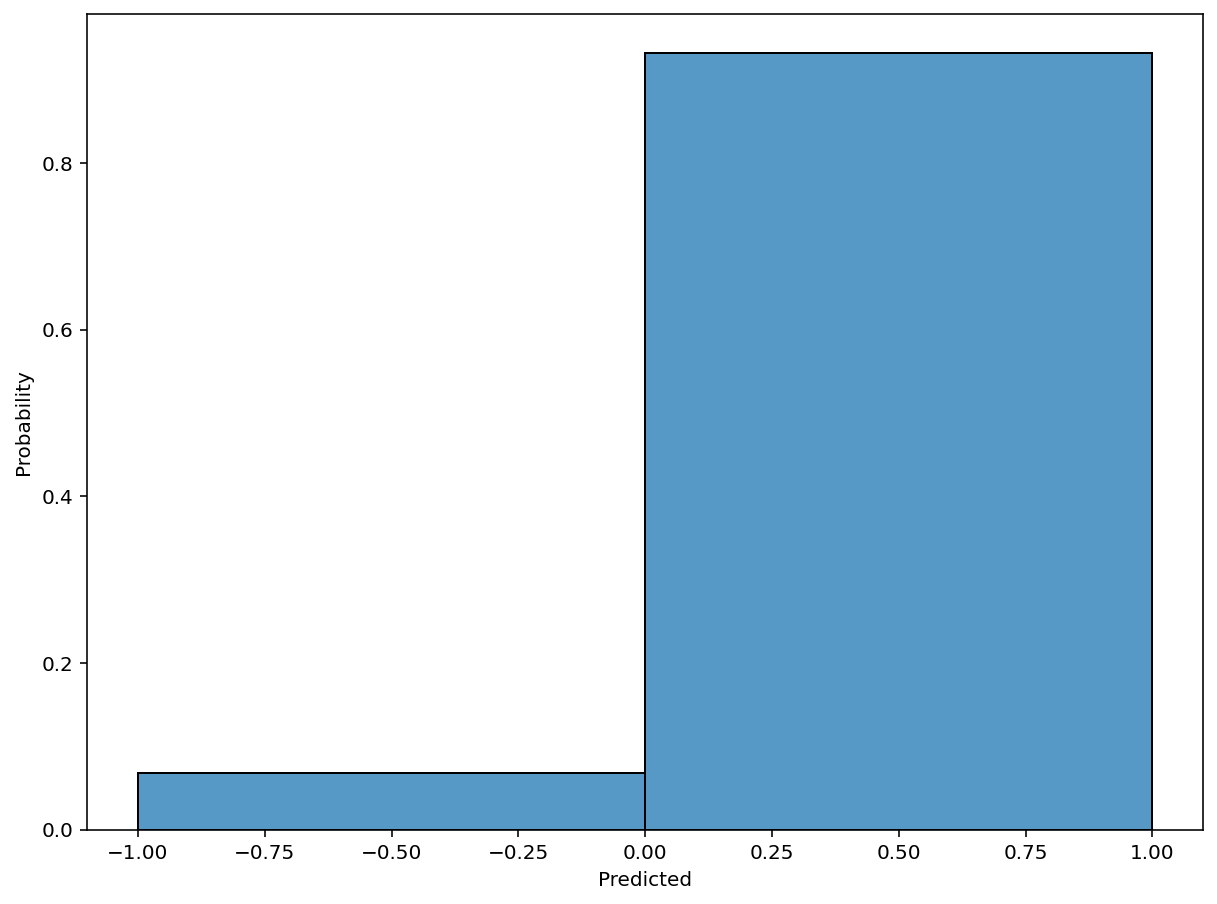

In [72]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df_2, x='Predicted', binwidth=(1), binrange=(-1,1), stat="probability")
None

In [73]:
best_predictions_2 = df_2.sort_values(by='err')[:10]
worst_predictions_2 = df_2.sort_values(by='err',ascending=False)[:10]

In [74]:
best_predictions_2.merge(filt_2, left_on='MovieId', right_on='movieId').drop(axis=1, labels='movieId')

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err,title,rating_2 mean
0,249,115713,1.00,1.00,792,20,0.00,Ex Machina (2015),0.71
1,492,494,1.00,1.00,95,33,0.00,Executive Decision (1996),0.61
2,105,104069,1.00,1.00,550,3,0.00,Louis C.K.: Oh My God (2013),1.00
3,366,32587,1.00,1.00,22,60,0.00,Sin City (2005),0.81
4,339,1259,1.00,1.00,283,70,0.00,Stand by Me (1986),0.96
5,523,7153,1.00,1.00,58,144,0.00,"Lord of the Rings: The Return of the King, The...",0.88
6,354,1208,1.00,1.00,171,81,0.00,Apocalypse Now (1979),0.89
7,105,44191,1.00,1.00,550,78,0.00,V for Vendetta (2006),0.88
8,477,2600,1.00,1.00,449,18,0.00,eXistenZ (1999),0.73
9,1,3053,1.00,1.00,180,8,0.00,"Messenger: The Story of Joan of Arc, The (1999)",1.00


In [75]:
worst_predictions_2.merge(filt_2, left_on='MovieId', right_on='movieId').drop(axis=1, labels='movieId')

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err,title,rating_2 mean
0,200,8949,-1.00,1.00,257,25,2.00,Sideways (2004),0.74
1,251,50872,-1.00,1.00,17,56,2.00,Ratatouille (2007),0.86
2,599,1079,-1.00,1.00,1889,61,2.00,"Fish Called Wanda, A (1988)",0.75
3,484,74458,-1.00,1.00,204,51,2.00,Shutter Island (2010),0.79
4,246,3949,-1.00,1.00,167,73,2.00,Requiem for a Dream (2000),0.79
5,484,55820,-1.00,1.00,204,49,2.00,No Country for Old Men (2007),0.81
6,256,5618,-1.00,1.00,125,64,2.00,Spirited Away (Sen to Chihiro no kamikakushi) ...,0.91
7,103,88125,-1.00,1.00,286,37,2.00,Harry Potter and the Deathly Hallows: Part 2 (...,0.72
8,280,94677,-1.00,1.00,152,13,2.00,"Dictator, The (2012)",0.53
9,454,2997,-1.00,1.00,36,78,2.00,Being John Malkovich (1999),0.84


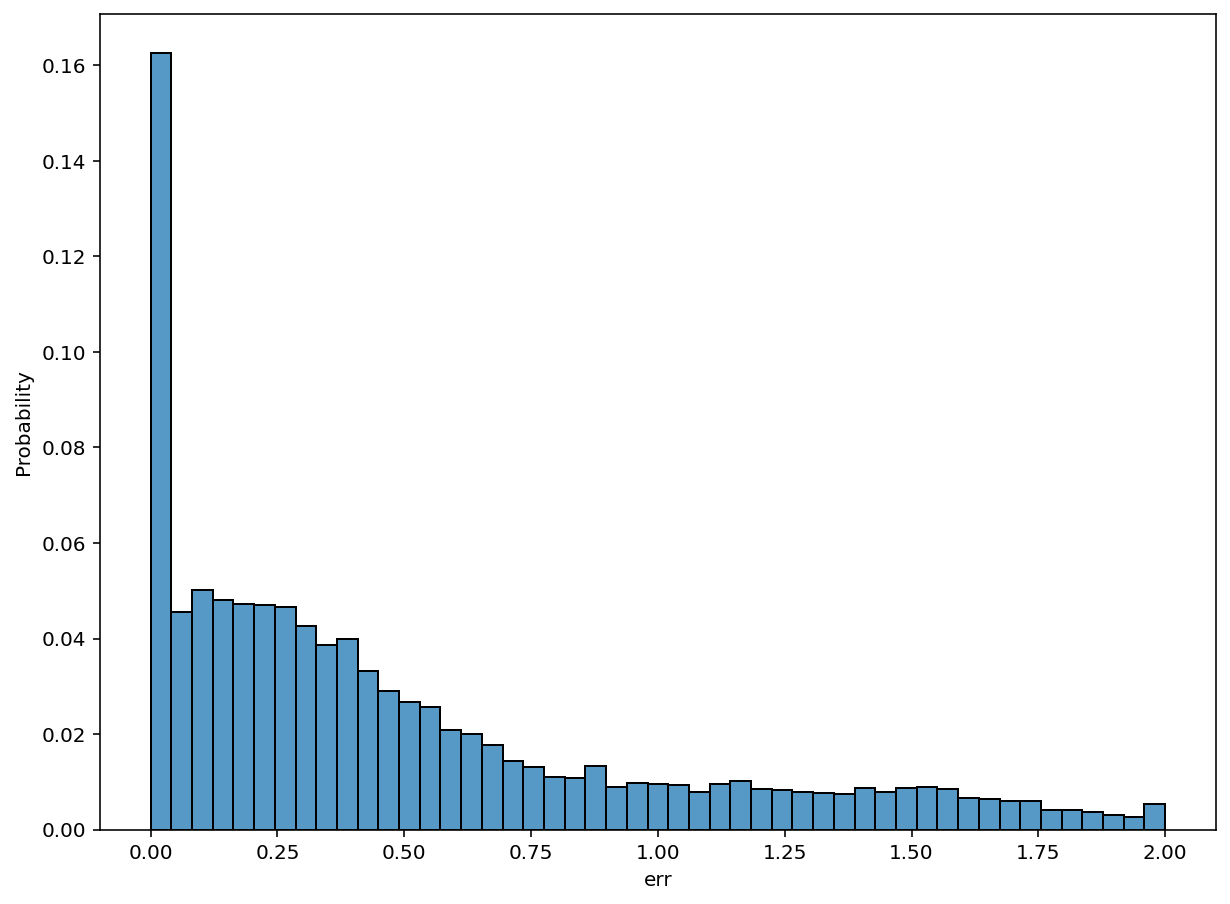

In [76]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df_2, x='err', binrange=(0,2), stat="probability")
None

80% 정도가 옳은 추천.

## Classification

- 0 보다 큰 Prediction 값은 1 (좋아요)로 변환
- 0 보다 작은 Prediction 값은 0 (싫어요)로 변환

In [77]:
df_2_edited = df_2.copy()
df_2_edited['Predicted']=df_2_edited['Predicted'].apply(lambda x: np.where(x > 0, (1),x))
df_2_edited['Predicted']=df_2_edited['Predicted'].apply(lambda x: np.where(x < 0, (-1),x))
df_2_edited['err'] = abs(df_2_edited.Predicted - df_2_edited.UserRating) # 예측값과 실제값의 차이
df_2_edited

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
0,166,2628,1.00,1.00,150,102,0.00
1,599,1982,1.00,-1.00,1889,18,2.00
2,260,6375,1.00,1.00,109,0,0.00
3,380,7845,1.00,1.00,911,3,0.00
4,249,114074,1.00,1.00,792,2,0.00
...,...,...,...,...,...,...,...
25204,19,541,1.00,1.00,539,93,0.00
25205,178,349,1.00,1.00,48,80,0.00
25206,223,32587,1.00,1.00,55,60,0.00
25207,68,56174,1.00,1.00,956,51,0.00


In [78]:
y_true_2 = df_2_edited['UserRating']
y_pred_2 = df_2_edited['Predicted']

cm_2 = confusion_matrix(y_true_2, y_pred_2, labels=[-1,1])

In [79]:
cm_2_df = pd.DataFrame(cm_2, columns = [-1,1], index = [-1, 1])

cm_2_df

,-1,1
-1,1072,3704
1,637,19796


In [80]:
(637+3704)/25209

0.17220040461739855

In [81]:
tn, fp, fn, tp = confusion_matrix(y_true_2, y_pred_2).ravel()
(tn, fp, fn, tp)

(1072, 3704, 637, 19796)

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_true_2, y_pred_2, labels=[-1,1]))

              precision    recall  f1-score   support

          -1       0.63      0.22      0.33      4776
           1       0.84      0.97      0.90     20433

    accuracy                           0.83     25209
   macro avg       0.73      0.60      0.62     25209
weighted avg       0.80      0.83      0.79     25209



# 3단계 - New

In [83]:
df_3 = pd.DataFrame(predictions_3, columns=['UserId', 'MovieId', 'UserRating', 'Predicted','details'])    
df_3 = df_3.drop(axis=1, labels='details')
df_3['# of reviews User Gave'] = df_3.UserId.apply(get_Iu) # 유저가 영화를 평가한 횟수.
df_3['# of reviews received (Movie)'] = df_3.MovieId.apply(get_Ui) # 영화가 리뷰를 받은 횟수
df_3['err'] = abs(df_3.Predicted - df_3.UserRating) # 예측값과 실제값의 차이

In [84]:
filt_3 = movie_ratings.filter(items=['title', 'movieId', 'rating_3 mean'])

In [85]:
df_3

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
0,166,2628,0.00,0.17,150,102,0.17
1,599,1982,0.00,-0.18,1889,18,0.18
2,260,6375,0.00,0.28,109,0,0.28
3,380,7845,1.00,0.24,911,3,0.76
4,249,114074,1.00,0.38,792,2,0.62
...,...,...,...,...,...,...,...
25204,19,541,1.00,-0.00,539,93,1.00
25205,178,349,1.00,0.66,48,80,0.34
25206,223,32587,1.00,0.24,55,60,0.76
25207,68,56174,0.00,0.28,956,51,0.28


#### 최고의 추천 - Top 10

In [86]:
best_predictions_3 = df_3.sort_values(by='err')[:10]
worst_predictions_3 = df_3.sort_values(by='err',ascending=False)[:10]

In [87]:
best_predictions_3.merge(filt_3, left_on='MovieId', right_on='movieId').drop(axis=1, labels='movieId')

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err,title,rating_3 mean
0,452,1356,1.00,1.00,151,70,0.00,Star Trek: First Contact (1996),0.60
1,452,1270,1.00,1.00,151,132,0.00,Back to the Future (1985),0.65
2,441,47,1.00,1.00,34,149,0.00,Seven (a.k.a. Se7en) (1995),0.63
3,601,908,1.00,1.00,69,39,0.00,North by Northwest (1959),0.75
4,290,1250,1.00,1.00,198,33,0.00,"Bridge on the River Kwai, The (1957)",0.67
5,452,3578,1.00,1.00,151,118,0.00,Gladiator (2000),0.61
6,122,1136,1.00,1.00,216,102,0.00,Monty Python and the Holy Grail (1975),0.70
7,290,928,1.00,1.00,198,12,0.00,Rebecca (1940),0.78
8,252,81845,1.00,1.00,29,38,0.00,"King's Speech, The (2010)",0.71
9,291,54001,1.00,1.00,20,39,0.00,Harry Potter and the Order of the Phoenix (2007),0.60


추천된 영화 모두 평균적으로 높은 평균 평점 (0.60이상)을 받고 있고

영화 Rebecca를 제외하곤 모든 영화들이 30번 이상의 리뷰점수를 받았다.

#### 최악의 추천 - Worst 10


In [88]:
worst_predictions_3.merge(filt_3, left_on='MovieId', right_on='movieId').drop(axis=1, labels='movieId')

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err,title,rating_3 mean
0,453,3052,-1.00,1.00,226,47,2.00,Dogma (1999),0.44
1,413,1198,-1.00,1.00,42,147,2.00,Raiders of the Lost Ark (Indiana Jones and the...,0.79
2,410,296,-1.00,1.00,127,216,2.00,Pulp Fiction (1994),0.74
3,534,99114,-1.00,1.00,384,50,2.00,Django Unchained (2012),0.62
4,441,527,-1.00,1.00,34,166,2.00,Schindler's List (1993),0.74
5,246,3949,-1.00,1.00,167,73,2.00,Requiem for a Dream (2000),0.62
6,256,5618,-1.00,1.00,125,64,2.00,Spirited Away (Sen to Chihiro no kamikakushi) ...,0.77
7,201,1748,-1.00,1.00,93,38,2.00,Dark City (1998),0.54
8,367,1278,-1.00,1.00,150,53,2.00,Young Frankenstein (1974),0.71
9,1,1219,-1.00,1.00,180,58,2.00,Psycho (1960),0.70


위의 영화중에서 반 이상이 0.70 이상의 좋은 평균 리뷰 점수를 받았고
또한 사용자에게 30번 이상의 리뷰를 받았다. (영화의 평균 평점은 믿을만하다)

In [89]:
tmp = users[users['userId']==413]
tmp = tmp.append(users[users['userId']==410])
tmp = tmp.append(users[users['userId']==534])
tmp = tmp.append(users[users['userId']==441])
tmp = tmp.append(users[users['userId']==256])
tmp.filter(items=['userId','rating count', 'rating_3 mean'])

,userId,rating count,rating_3 mean
412,413,56,0.75
409,410,167,0.74
533,534,520,0.58
440,441,45,0.89
255,256,174,0.72


413, 410, 534, 441, 256 번 사용자 모두 긍정적인 평가를 내렸다. (0.33 이상)

그리고 영화들도 0.33이상의 평균 리뷰점수를 받으며 사용자들에게 긍정적인 평가를 받고있다.

**결론**

유저의 취향을 적극적으로 반영하지 못한 추천모델성능.

긍정적인 사실로는 추천모델이 유저에게 최악을 추천을 할 확률은 5%정도이다. (아래 그래프 참고)

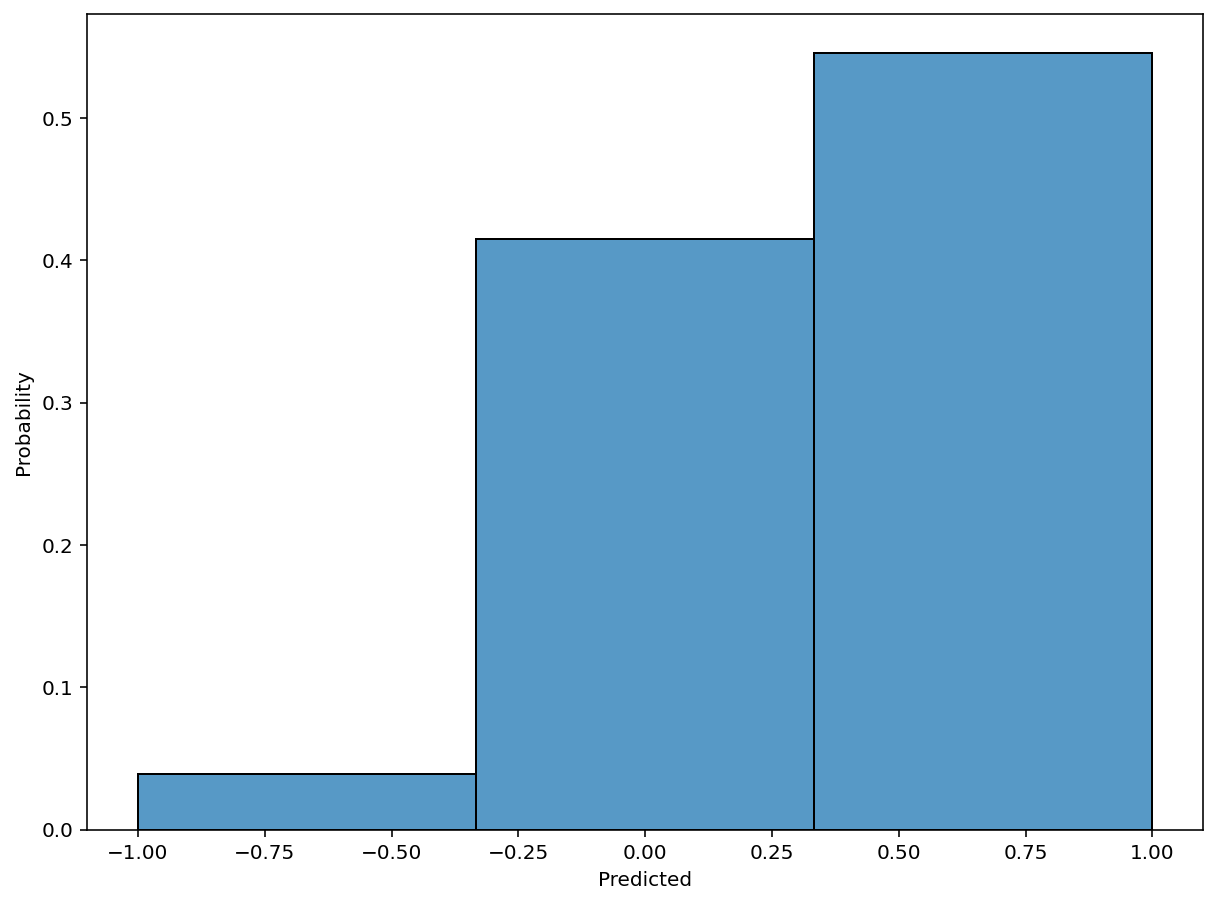

In [90]:
# TEST SET ... 
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df_3, x='Predicted', binwidth=(2/3), binrange=(-1,1), stat="probability")
None

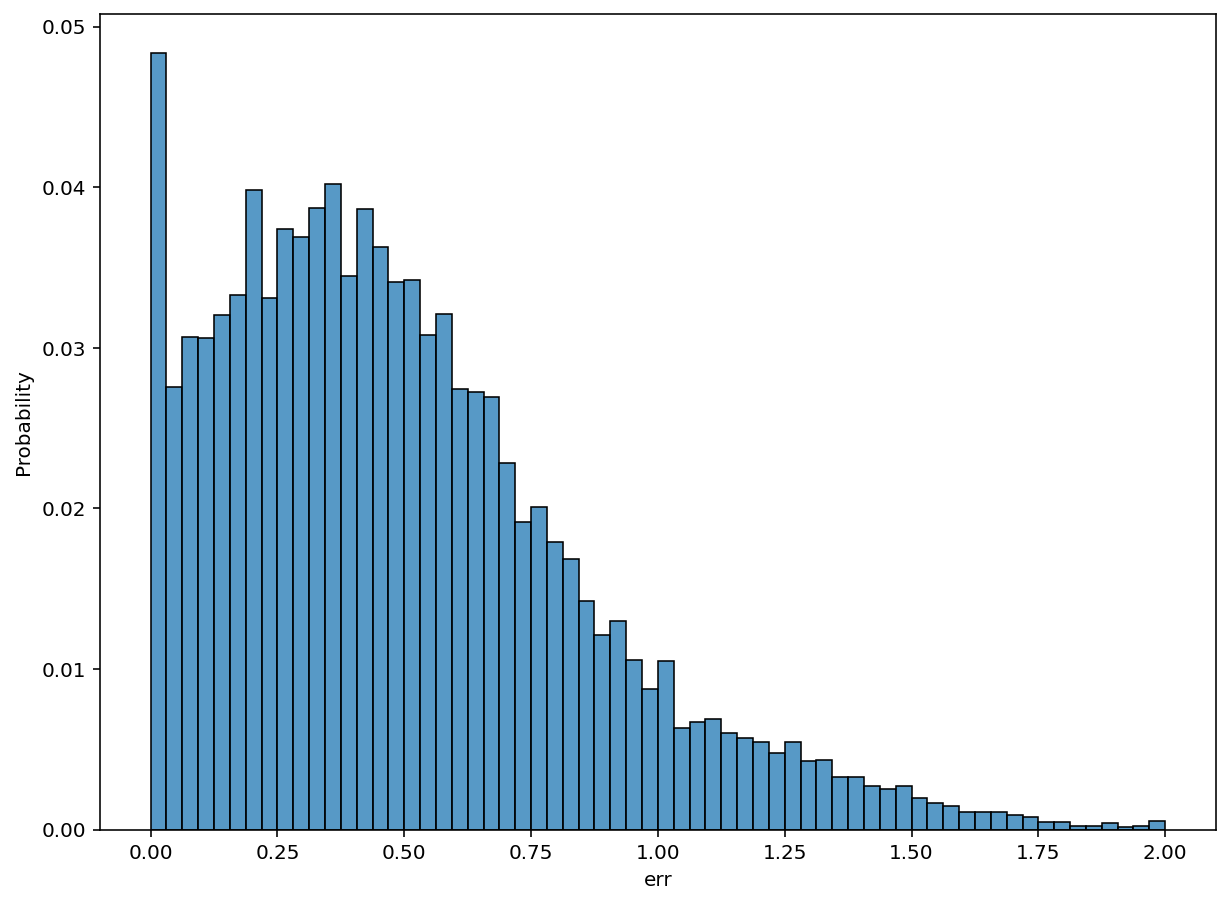

In [91]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df_3, x='err', binrange=(0,2), stat="probability")
None

## Classification

- 0.33 보다 높은 Prediction 값은 1 로 변환
- -0.33과 0.33사이에 있는 Prediction 값은 0 으로 변환
- -0.33보다 낮은 Prediction 값은 -1 으로 변환

In [92]:
df_3_edited = df_3.copy()
df_3_edited['Predicted']=df_3_edited['Predicted'].apply(lambda x: np.where(x > (1/3), (1),x))
df_3_edited['Predicted']=df_3_edited['Predicted'].apply(lambda x: np.where(x > (-1/3) and x < (1/3), (0),x))
df_3_edited['Predicted']=df_3_edited['Predicted'].apply(lambda x: np.where(x < (-1/3), (-1),x))
df_3_edited['err'] = abs(df_3_edited.Predicted - df_3_edited.UserRating) # 예측값과 실제값의 차이
df_3_edited

,UserId,MovieId,UserRating,Predicted,# of reviews User Gave,# of reviews received (Movie),err
0,166,2628,0.00,0.00,150,102,0.00
1,599,1982,0.00,0.00,1889,18,0.00
2,260,6375,0.00,0.00,109,0,0.00
3,380,7845,1.00,0.00,911,3,1.00
4,249,114074,1.00,1.00,792,2,0.00
...,...,...,...,...,...,...,...
25204,19,541,1.00,0.00,539,93,1.00
25205,178,349,1.00,1.00,48,80,0.00
25206,223,32587,1.00,0.00,55,60,1.00
25207,68,56174,0.00,0.00,956,51,0.00


In [93]:
y_true_3 = df_3_edited['UserRating']
y_pred_3 = df_3_edited['Predicted']

cm_3 = confusion_matrix(y_true_3, y_pred_3, labels=[-1,0,1])

In [94]:
cm_3_df = pd.DataFrame(cm_3, columns = [-1,0,1], index = [-1, 0, 1])

cm_3_df

,-1,0,1
-1,557,2170,654
0,379,5311,3916
1,57,2979,9186


columns are actual

rows are predicted

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_true_3, y_pred_3, labels=[-1,0,1]))

              precision    recall  f1-score   support

          -1       0.56      0.16      0.25      3381
           0       0.51      0.55      0.53      9606
           1       0.67      0.75      0.71     12222

    accuracy                           0.60     25209
   macro avg       0.58      0.49      0.50     25209
weighted avg       0.59      0.60      0.58     25209



새로운 3단계 리뷰시스템은

60% 예측 정확도를 보이고 있다. (true_-1, true_0, true_1)

In [96]:
(557+2170+379+5311+3916+2979+9186)/25209

0.9717957872188504

In [97]:
(654+57)/25209

0.02820421278114959

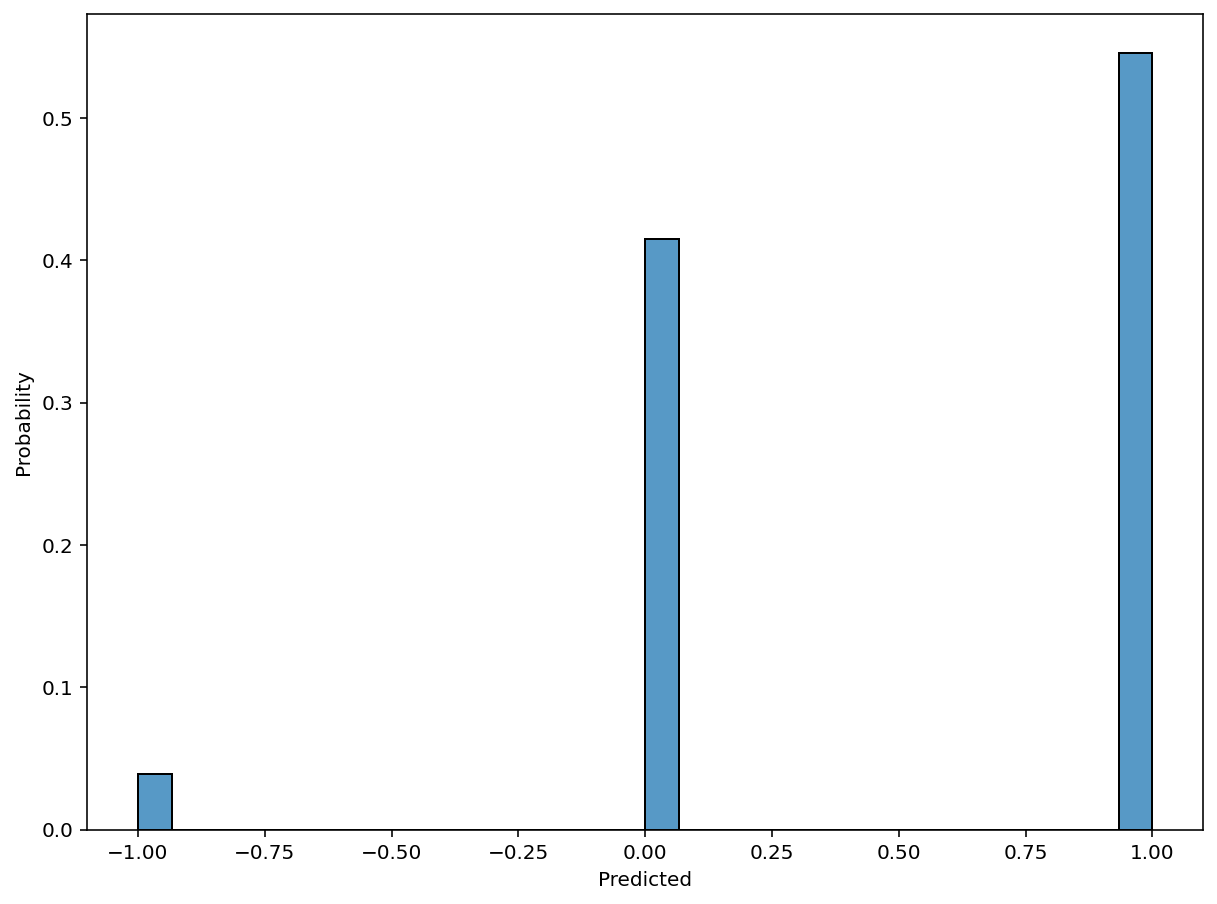

In [98]:
plt.figure(figsize=(10, 7.5))
sns.histplot(data=df_3_edited, x='Predicted', binrange=(-1,1), stat="probability")
None

# 결론

### Collaborative Filtering Algorithm
일반적으로 사용되는 k nearest neghibor 알고리즘보다, Singular Value Deposition 알고리즘이 성능이 더 좋음.

- 5점 만점 리뷰시스템 기준
|KNN|SVD|
|-|-|
|0.98|0.87|

### 5점 만점, 2단계 3단계 리뷰시스템을 비교해 보았을떄 
새롭게 제시된 3단계 평가시스템의 RMSE 값이 제일 작았다. 다르게 말하면 성능이 제일 좋았다, 오차값이 제일 작음.

||5점 만점|2단계|3단계|
|-|-|-|-|
|SVD - RMSE|0.8708|0.7065|0.6058|

  

### RMSE 값이 작다고해서 무조건 사용자에게 알맞는 추천을 하는것은 아니다.
예) 최악의 추천 분석

- 2단계 시스템
    - 추천 정확도 : 87%
    - 최악의 추천을 할 확률 13%

- 3단계 시스템
    - 추천 정확도 : 60%
    - 1단계 오차로 추천할 확률 : 37%
    - 최악의 추천을 할 확률 : 3%

### 더 나은 추천모델을 만들기 위해서...
아이템의 Feature와 사용자들의 평점을 반영하는 Hybrid Recommender System을 개발.